# Import Libraries

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import random
import simpy
from datetime import datetime

# Declare Supporting Functions

## Convert Runtime into Expected Drive Time and Dwell Time

Physics Calculation: time to travel a given distance based on acceleration and max velocity

In [2]:
def timeTo(a, maxV, d):
    # a       constant acceleration, m/s²
    # maxV    maximumum velocity, m/s
    # d       distance, km
    # return  time in seconds required to travel
    # 
    ta = maxV/a         # time to accelerate to maxV
    da = a*ta**2        # distance traveled during acceleration from 0 to maxV and back to 0
    if (d < da):        # train never reaches full speed?
        return np.sqrt(4.0*d/a)     # time needed to accelerate to half-way point then decelerate to destination
    else:
        return 2*ta + (d-da)/maxV   # time to accelerate to maxV plus travel at maxV plus decelerate to destination

### Function to calculate the time to stop

In [3]:
def timeToDecelerate(a, maxV):
    return maxV/a

### Generate Delay with Log normal distribution μ=3 and σ=1

In [4]:
def delay():
        mu, sigma = 3., 1. # mean and standard deviation
        s = np.random.lognormal(mu, sigma, 1)
        return s

### Creating a global dictionary to keep a track of the signal status

In [5]:
signal_dict = {}

### Functions to Change Signals

In [6]:
 def switchSignal(self,signal):
        if signal == 1 or signal == 0:
            signal_dict[signal]= False
            return signal_dict
        else:
            signal_dict[signal-1] = False
            return signal_dict

In [7]:
def switchSignal_2(self,signal):
    if signal == 1:
        signal_dict[signal]= True
        return signal_dict
    elif signal == 0:
        signal_dict[signal]= True
        return signal_dict
    else:
        signal_dict[signal-1] = True
        return signal_dict

### Checking for delay with a probability distribution of 85% and 15% for False and True respectively

In [8]:
def isdelay():
    return random.choices((False,True),weights=[85,15],k=1)

### Creating a global Dataframe to store simulation results for every run

In [9]:
df_schedule = pd.DataFrame(columns=['Departure_Time','Train_Number','Arrival_Time','Scheduled_Travel_Time(min)','Travel_Time(min)','Inter_Arrival_Time(min)', 'Number_of_Signals'])

# Modelling

Components of the system will be described by Python classes. The parameters are passed as data frames.

## Trains

In [10]:
class Train(object):  
    def __init__(self, i, maxAcc = 0.76, maxV = 86.1, d=145000, em_dec = 2.5, opt_dec = 0.38 ):
        self.accel = maxAcc                 # Maximum Acceleration
        self.maxV  = maxV                   # Maximum Velocity
        self.dist  = d                      # Distance between London Old Oak Commons and Birmingham Interchange
        self.em_dec= em_dec                 # Emergency Deceleration
        self.opt_dec= opt_dec               # Optimal Deceleration  
        self.name = f"[Train {i:2d}]"       # Name of the Train
        self.machine = simpy.Resource(env, capacity=1)   # Defining resource
       
    def engagelock(self,signals,dist_bet_sig_blocks): 
        with self.machine.request() as request:
            yield request                                  # Lock the resource/signal
            for signal in range(0,signals):
                switchSignal(self,signal)                  # Switch the previous signal to red
                if signal_dict.get(signal+1) is False:     # Check for the status of the next signal
                    if dist_bet_sig_blocks >= 9722:
                        yield env.timeout(timeToDecelerate(self.opt_dec, self.maxV))  # Decelerate to the next signal
                    else:
                        yield env.timeout(timeToDecelerate(self.em_dec, self.maxV))   # Decelerate to the next signal
                    
                while signal_dict.get(signal+1) is False :  # Wait until the next signal turns Green
                    print(f"{now():s} {self.name:s} is waiting for Signal {signal+1} to turn GREEN")                    
                    yield env.timeout(60)
                else:
                    if isdelay()[0] == True:                # Switch the previous signal red if there is a delay
                        switchSignal(self,signal)
                        time_delay=round(delay()[0],2)
                        print(f"\n{now():s} {self.name:s} is experiencing a delay of {round((time_delay)/60,2)} min at Signal {signal}")
                        yield env.timeout(round(time_delay*10,2))
                    switchSignal_2(self,signal)             # Switch the signal to Green
        
        
    def releaselock(self): 
        yield env.timeout(5)
        self.machine.put()                                  # Release the resource    
        
    def process(self,k,timing,dist_bet_sig_blocks):
        global df_schedule
        here = 'London Old Oak Commons'           
        dest = 'Birmingham Interchange'
        t1=env.now
        dept_time=now()
        print(f"{now():s} {self.name:s} Departed from {here:s}")
        
        drivetime=timeTo(self.accel, self.maxV, self.dist)
        yield env.process(self.engagelock(k,dist_bet_sig_blocks))       # Acquire Resource lock
        yield env.process(self.releaselock())                           # Release Resource lock  
        yield env.timeout(drivetime)
        travel_time = round((env.now-t1)/60,2)
        print(f"{now():s} {self.name:s} has arrived at {dest:s}, Travelling time {travel_time} mins")
        dfobj = {'Departure_Time':dept_time,'Train_Number':self.name,'Arrival_Time':now(),'Scheduled_Travel_Time(min)': 29.96,'Travel_Time(min)':travel_time,'Inter_Arrival_Time(min)':timing/60,'Delay(min)': travel_time-29.96 ,'Number_of_Signals':k}
        df_schedule=df_schedule.append(dfobj, ignore_index=True)        # Updating the Dataframe for the current run

## Tracks

In [11]:
def track(start, stop, timing, incident, incidentTime):
    
    yield env.timeout(start-env.now)                              # the line starts operating at 7AM
    incidentTime = (incidentTime - start)/timing                  # The time for the incident
    k = random.randint(1,30)                                      # Generating the number of signals
    dist_bet_sig_blocks = round(145/k+1,2)                        # Calculating the distance between signalling blocks
    signal_dict = dict.fromkeys((i for i in range(k)),True)       # Initialising the Global dictionary with TRUE
    print(f"Total number of Signal Blocks {k}")
    print(f"Distance Between signalling blocks is {dist_bet_sig_blocks}km")
    for i in range(int((stop-start)/timing)+1):
        while signal_dict.get(0) is False:
            print(f"Train waiting to depart, congestion ahead!")  
            yield env.timeout(60)
        else:
            if incident is True:
                if i==incidentTime:
                    print(f'\033[1m'+"There has been a temporary incident, a delay of 30 minutes is expected for the 9AM train"+'\033[0m')
                    yield env.timeout(1800)
                    t = Train(i)
                    env.process(t.process(k,timing,dist_bet_sig_blocks*1000))
                    yield env.timeout(timing)
                else:
                    t = Train(i)
                    env.process(t.process(k,timing,dist_bet_sig_blocks*1000))
                    yield env.timeout(timing)
            
            

# Utilities

Format time in seconds as hh:mm:ss

In [12]:
def daytime(t):
    t=int(t)
    return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
def now():
    return daytime(env.now)

### Function to get normal distribution of the Inter-Arrival Time for various runs

In [13]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [14]:
X = get_truncated_normal(mean=30, sd=10, low=1, upp=120)

### Running the simulation and storing the results of every run in a CSV file and clearing the df_schedule dataframe for getting the values of the next run

In [17]:
i=0
while i<100:
    env = simpy.Environment()
    env.process(track(start=7*3600, stop=22*3600, timing=round(X.rvs()*100,2), incident=True, incidentTime=9*3600))
    env.run()
    df_schedule.to_csv(f'train_sim/train_sim_run_{i}.csv', index=False)
    df_schedule=df_schedule[0:0]
    i+=1

Total number of Signal Blocks 12
Distance Between signalling blocks is 13.08km
07:00:00 [Train  0] Departed from London Old Oak Commons

07:00:00 [Train  0] is experiencing a delay of 0.27 min at Signal 10
07:32:44 [Train  0] has arrived at Birmingham Interchange, Travelling time 32.73 mins
07:51:40 [Train  1] Departed from London Old Oak Commons

07:51:40 [Train  1] is experiencing a delay of 0.32 min at Signal 0

07:54:50 [Train  1] is experiencing a delay of 0.16 min at Signal 5
08:26:30 [Train  1] has arrived at Birmingham Interchange, Travelling time 34.82 mins
08:43:21 [Train  2] Departed from London Old Oak Commons

08:43:21 [Train  2] is experiencing a delay of 0.09 min at Signal 2

08:44:16 [Train  2] is experiencing a delay of 0.36 min at Signal 5

08:47:52 [Train  2] is experiencing a delay of 0.47 min at Signal 6

08:52:34 [Train  2] is experiencing a delay of 0.46 min at Signal 8
09:27:12 [Train  2] has arrived at Birmingham Interchange, Travelling time 43.85 mins
09:35:02

11:10:54 [Train  5] Departed from London Old Oak Commons

11:10:54 [Train  5] is experiencing a delay of 1.01 min at Signal 0

11:20:58 [Train  5] is experiencing a delay of 0.47 min at Signal 3

11:25:43 [Train  5] is experiencing a delay of 0.37 min at Signal 12
11:59:29 [Train  5] has arrived at Birmingham Interchange, Travelling time 48.57 mins
12:01:05 [Train  6] Departed from London Old Oak Commons

12:01:05 [Train  6] is experiencing a delay of 2.42 min at Signal 8

12:25:16 [Train  6] is experiencing a delay of 1.18 min at Signal 9

12:37:01 [Train  6] is experiencing a delay of 1.16 min at Signal 11
12:51:16 [Train  7] Departed from London Old Oak Commons

12:51:16 [Train  7] is experiencing a delay of 0.12 min at Signal 4
13:18:39 [Train  6] has arrived at Birmingham Interchange, Travelling time 77.57 mins
13:22:33 [Train  7] has arrived at Birmingham Interchange, Travelling time 31.27 mins
13:41:27 [Train  8] Departed from London Old Oak Commons

13:41:27 [Train  8] is exper

19:25:05 [Train 22] has arrived at Birmingham Interchange, Travelling time 65.61 mins

19:26:48 [Train 24] is experiencing a delay of 0.43 min at Signal 11
19:26:53 [Train 23] has arrived at Birmingham Interchange, Travelling time 36.52 mins

19:31:03 [Train 24] is experiencing a delay of 0.79 min at Signal 13

19:38:57 [Train 24] is experiencing a delay of 0.12 min at Signal 19
19:52:08 [Train 25] Departed from London Old Oak Commons

19:52:08 [Train 25] is experiencing a delay of 0.37 min at Signal 1

19:55:47 [Train 25] is experiencing a delay of 1.28 min at Signal 16
20:10:09 [Train 24] has arrived at Birmingham Interchange, Travelling time 48.9 mins
20:23:01 [Train 26] Departed from London Old Oak Commons

20:23:01 [Train 26] is experiencing a delay of 0.49 min at Signal 4

20:27:53 [Train 26] is experiencing a delay of 1.22 min at Signal 7
20:38:38 [Train 25] has arrived at Birmingham Interchange, Travelling time 46.51 mins

20:40:06 [Train 26] is experiencing a delay of 1.27 min

08:49:59 [Train  2] Departed from London Old Oak Commons
09:20:01 [Train  2] has arrived at Birmingham Interchange, Travelling time 30.04 mins
09:44:58 [Train  3] Departed from London Old Oak Commons

09:44:58 [Train  3] is experiencing a delay of 0.14 min at Signal 5
10:16:27 [Train  3] has arrived at Birmingham Interchange, Travelling time 31.48 mins
10:39:58 [Train  4] Departed from London Old Oak Commons

10:39:58 [Train  4] is experiencing a delay of 0.23 min at Signal 5

10:42:15 [Train  4] is experiencing a delay of 0.13 min at Signal 6
11:13:37 [Train  4] has arrived at Birmingham Interchange, Travelling time 33.65 mins
11:34:58 [Train  5] Departed from London Old Oak Commons

11:34:58 [Train  5] is experiencing a delay of 0.42 min at Signal 7
12:09:10 [Train  5] has arrived at Birmingham Interchange, Travelling time 34.2 mins
12:29:57 [Train  6] Departed from London Old Oak Commons

12:29:57 [Train  6] is experiencing a delay of 0.57 min at Signal 2

12:35:41 [Train  6] is exp

09:06:50 [Train  8] Departed from London Old Oak Commons

09:06:50 [Train  8] is experiencing a delay of 0.11 min at Signal 0

09:07:04 [Train  7] is experiencing a delay of 0.13 min at Signal 6
09:21:00 [Train  4] has arrived at Birmingham Interchange, Travelling time 77.6 mins
09:22:41 [Train  9] Departed from London Old Oak Commons

09:22:41 [Train  9] is experiencing a delay of 0.47 min at Signal 1

09:27:22 [Train  9] is experiencing a delay of 3.57 min at Signal 6
09:36:30 [Train  6] has arrived at Birmingham Interchange, Travelling time 61.38 mins
09:38:22 [Train  7] has arrived at Birmingham Interchange, Travelling time 47.39 mins
09:38:32 [Train 10] Departed from London Old Oak Commons
09:41:42 [Train  8] has arrived at Birmingham Interchange, Travelling time 34.87 mins
09:42:19 [Train 10] is waiting for Signal 5 to turn GREEN
09:43:19 [Train 10] is waiting for Signal 5 to turn GREEN
09:44:19 [Train 10] is waiting for Signal 5 to turn GREEN
09:45:19 [Train 10] is waiting for S

14:14:15 [Train 25] has arrived at Birmingham Interchange, Travelling time 37.91 mins
14:23:55 [Train 28] Departed from London Old Oak Commons

14:23:55 [Train 28] is experiencing a delay of 0.3 min at Signal 1
14:25:18 [Train 26] has arrived at Birmingham Interchange, Travelling time 33.1 mins

14:26:53 [Train 28] is experiencing a delay of 0.39 min at Signal 2

14:30:46 [Train 28] is experiencing a delay of 0.67 min at Signal 3

14:37:28 [Train 28] is experiencing a delay of 0.42 min at Signal 9
14:39:46 [Train 29] Departed from London Old Oak Commons

14:39:46 [Train 29] is experiencing a delay of 0.1 min at Signal 1

14:40:48 [Train 29] is experiencing a delay of 0.3 min at Signal 5
14:41:20 [Train 27] has arrived at Birmingham Interchange, Travelling time 33.28 mins
14:55:37 [Train 30] Departed from London Old Oak Commons

14:55:37 [Train 30] is experiencing a delay of 0.66 min at Signal 4

15:02:15 [Train 30] is experiencing a delay of 0.15 min at Signal 9

15:03:43 [Train 30] is

20:00:54 [Train 12] Departed from London Old Oak Commons

20:00:54 [Train 12] is experiencing a delay of 0.32 min at Signal 7

20:04:04 [Train 12] is experiencing a delay of 0.69 min at Signal 16
20:41:01 [Train 12] has arrived at Birmingham Interchange, Travelling time 40.13 mins
21:05:58 [Train 13] Departed from London Old Oak Commons

21:05:58 [Train 13] is experiencing a delay of 0.33 min at Signal 7

21:09:18 [Train 13] is experiencing a delay of 0.1 min at Signal 10

21:10:16 [Train 13] is experiencing a delay of 0.59 min at Signal 11
21:46:11 [Train 13] has arrived at Birmingham Interchange, Travelling time 40.21 mins
Total number of Signal Blocks 7
Distance Between signalling blocks is 21.71km
07:00:00 [Train  0] Departed from London Old Oak Commons

07:00:00 [Train  0] is experiencing a delay of 0.58 min at Signal 3
07:35:47 [Train  0] has arrived at Birmingham Interchange, Travelling time 35.79 mins
07:54:10 [Train  1] Departed from London Old Oak Commons

07:54:10 [Train  1]

Total number of Signal Blocks 6
Distance Between signalling blocks is 25.17km
07:00:00 [Train  0] Departed from London Old Oak Commons
07:30:02 [Train  0] has arrived at Birmingham Interchange, Travelling time 30.04 mins
07:32:45 [Train  1] Departed from London Old Oak Commons
08:02:47 [Train  1] has arrived at Birmingham Interchange, Travelling time 30.04 mins
08:05:30 [Train  2] Departed from London Old Oak Commons
08:35:33 [Train  2] has arrived at Birmingham Interchange, Travelling time 30.04 mins
08:38:16 [Train  3] Departed from London Old Oak Commons

08:38:16 [Train  3] is experiencing a delay of 1.12 min at Signal 4
09:11:01 [Train  4] Departed from London Old Oak Commons

09:11:01 [Train  4] is experiencing a delay of 0.71 min at Signal 1

09:18:06 [Train  4] is experiencing a delay of 0.56 min at Signal 4
09:19:28 [Train  3] has arrived at Birmingham Interchange, Travelling time 41.2 mins
09:43:47 [Train  5] Departed from London Old Oak Commons

09:43:47 [Train  5] is experi

10:35:22 [Train 13] Departed from London Old Oak Commons

10:35:22 [Train 13] is experiencing a delay of 0.13 min at Signal 0

10:36:42 [Train 13] is experiencing a delay of 0.41 min at Signal 2

10:40:49 [Train 13] is experiencing a delay of 1.23 min at Signal 9
10:51:56 [Train 14] Departed from London Old Oak Commons

10:51:56 [Train 14] is experiencing a delay of 0.23 min at Signal 5
10:53:10 [Train 10] has arrived at Birmingham Interchange, Travelling time 67.5 mins
10:53:29 [Train 11] has arrived at Birmingham Interchange, Travelling time 51.24 mins
10:54:01 [Train 12] has arrived at Birmingham Interchange, Travelling time 35.21 mins

10:54:15 [Train 14] is experiencing a delay of 0.15 min at Signal 17
11:08:30 [Train 15] Departed from London Old Oak Commons

11:08:30 [Train 15] is experiencing a delay of 0.14 min at Signal 5

11:09:54 [Train 15] is experiencing a delay of 0.15 min at Signal 12
11:23:09 [Train 13] has arrived at Birmingham Interchange, Travelling time 47.78 mins
1

20:47:34 [Train 49] is waiting for Signal 14 to turn GREEN
20:48:22 [Train 50] Departed from London Old Oak Commons

20:48:22 [Train 50] is experiencing a delay of 0.16 min at Signal 1
20:48:34 [Train 49] is waiting for Signal 14 to turn GREEN
20:49:34 [Train 49] is waiting for Signal 14 to turn GREEN

20:49:59 [Train 50] is experiencing a delay of 0.06 min at Signal 7

20:50:32 [Train 50] is experiencing a delay of 0.55 min at Signal 9

20:56:01 [Train 50] is experiencing a delay of 0.67 min at Signal 13

21:02:45 [Train 50] is experiencing a delay of 0.47 min at Signal 14
21:04:57 [Train 51] Departed from London Old Oak Commons
21:05:31 [Train 51] is waiting for Signal 13 to turn GREEN
21:06:31 [Train 51] is waiting for Signal 13 to turn GREEN

21:07:27 [Train 50] is experiencing a delay of 0.59 min at Signal 16

21:07:31 [Train 51] is experiencing a delay of 0.33 min at Signal 13
21:11:26 [Train 51] is waiting for Signal 15 to turn GREEN
21:12:26 [Train 51] is waiting for Signal 15 

18:02:30 [Train 14] Departed from London Old Oak Commons

18:02:30 [Train 14] is experiencing a delay of 0.36 min at Signal 3

18:06:05 [Train 14] is experiencing a delay of 0.48 min at Signal 5
18:40:53 [Train 14] has arrived at Birmingham Interchange, Travelling time 38.39 mins
18:49:50 [Train 15] Departed from London Old Oak Commons

18:49:50 [Train 15] is experiencing a delay of 0.72 min at Signal 0

18:57:02 [Train 15] is experiencing a delay of 0.45 min at Signal 2

19:01:30 [Train 15] is experiencing a delay of 0.09 min at Signal 4

19:02:24 [Train 15] is experiencing a delay of 0.31 min at Signal 6

19:05:31 [Train 15] is experiencing a delay of 0.47 min at Signal 12
19:37:09 [Train 16] Departed from London Old Oak Commons

19:37:09 [Train 16] is experiencing a delay of 8.26 min at Signal 4
19:40:16 [Train 15] has arrived at Birmingham Interchange, Travelling time 50.45 mins
20:24:28 [Train 17] Departed from London Old Oak Commons
20:25:03 [Train 17] is waiting for Signal 3 to 

13:46:54 [Train 34] has arrived at Birmingham Interchange, Travelling time 37.59 mins

13:48:47 [Train 37] is experiencing a delay of 1.75 min at Signal 6
13:50:12 [Train 35] has arrived at Birmingham Interchange, Travelling time 30.04 mins
13:52:45 [Train 38] Departed from London Old Oak Commons

13:52:45 [Train 38] is experiencing a delay of 1.45 min at Signal 3
14:03:37 [Train 39] Departed from London Old Oak Commons

14:07:13 [Train 38] is experiencing a delay of 0.07 min at Signal 4

14:11:10 [Train 39] is experiencing a delay of 0.56 min at Signal 4
14:14:29 [Train 40] Departed from London Old Oak Commons

14:14:29 [Train 40] is experiencing a delay of 0.49 min at Signal 0
14:17:18 [Train 36] has arrived at Birmingham Interchange, Travelling time 46.28 mins
14:25:20 [Train 41] Departed from London Old Oak Commons

14:25:20 [Train 41] is experiencing a delay of 1.22 min at Signal 2
14:36:12 [Train 42] Departed from London Old Oak Commons
14:36:22 [Train 37] has arrived at Birmingh

21:05:09 [Train 77] is waiting for Signal 2 to turn GREEN
21:06:09 [Train 77] is waiting for Signal 2 to turn GREEN
21:07:09 [Train 77] is waiting for Signal 2 to turn GREEN
21:07:14 [Train 78] Departed from London Old Oak Commons
21:08:09 [Train 77] is waiting for Signal 2 to turn GREEN
21:09:09 [Train 77] is waiting for Signal 2 to turn GREEN
21:10:09 [Train 77] is waiting for Signal 2 to turn GREEN
21:11:01 [Train 78] is waiting for Signal 1 to turn GREEN
21:11:09 [Train 77] is waiting for Signal 2 to turn GREEN
21:12:01 [Train 78] is waiting for Signal 1 to turn GREEN
21:12:09 [Train 77] is waiting for Signal 2 to turn GREEN
21:13:01 [Train 78] is waiting for Signal 1 to turn GREEN
21:13:09 [Train 77] is waiting for Signal 2 to turn GREEN
21:14:01 [Train 78] is waiting for Signal 1 to turn GREEN
21:14:09 [Train 77] is waiting for Signal 2 to turn GREEN
21:15:01 [Train 78] is waiting for Signal 1 to turn GREEN
21:15:09 [Train 77] is waiting for Signal 2 to turn GREEN
21:16:01 [Train

16:15:43 [Train 18] Departed from London Old Oak Commons
16:27:40 [Train 17] has arrived at Birmingham Interchange, Travelling time 42.83 mins
16:45:45 [Train 18] has arrived at Birmingham Interchange, Travelling time 30.04 mins
16:46:35 [Train 19] Departed from London Old Oak Commons
17:16:37 [Train 19] has arrived at Birmingham Interchange, Travelling time 30.04 mins
17:17:28 [Train 20] Departed from London Old Oak Commons
17:47:30 [Train 20] has arrived at Birmingham Interchange, Travelling time 30.04 mins
17:48:20 [Train 21] Departed from London Old Oak Commons

17:48:20 [Train 21] is experiencing a delay of 0.64 min at Signal 0
18:19:12 [Train 22] Departed from London Old Oak Commons

18:19:12 [Train 22] is experiencing a delay of 0.09 min at Signal 3
18:24:46 [Train 21] has arrived at Birmingham Interchange, Travelling time 36.43 mins
18:50:05 [Train 23] Departed from London Old Oak Commons
18:50:08 [Train 22] has arrived at Birmingham Interchange, Travelling time 30.93 mins
19:2

14:11:28 [Train  6] has arrived at Birmingham Interchange, Travelling time 33.82 mins
14:43:56 [Train  7] Departed from London Old Oak Commons
15:13:58 [Train  7] has arrived at Birmingham Interchange, Travelling time 30.04 mins
15:50:12 [Train  8] Departed from London Old Oak Commons

15:50:12 [Train  8] is experiencing a delay of 0.16 min at Signal 3

15:51:46 [Train  8] is experiencing a delay of 0.13 min at Signal 7

15:53:07 [Train  8] is experiencing a delay of 0.24 min at Signal 9

15:55:28 [Train  8] is experiencing a delay of 1.03 min at Signal 11
16:35:50 [Train  8] has arrived at Birmingham Interchange, Travelling time 45.62 mins
16:56:29 [Train  9] Departed from London Old Oak Commons

16:56:29 [Train  9] is experiencing a delay of 0.06 min at Signal 2
17:27:05 [Train  9] has arrived at Birmingham Interchange, Travelling time 30.6 mins
18:02:45 [Train 10] Departed from London Old Oak Commons

18:02:45 [Train 10] is experiencing a delay of 0.17 min at Signal 2

18:04:28 [Tra

09:00:18 [Train  1] has arrived at Birmingham Interchange, Travelling time 76.69 mins
09:09:29 [Train  2] has arrived at Birmingham Interchange, Travelling time 42.25 mins
09:10:52 [Train  3] Departed from London Old Oak Commons

09:10:52 [Train  3] is experiencing a delay of 0.07 min at Signal 5

09:11:37 [Train  3] is experiencing a delay of 1.18 min at Signal 9

09:23:24 [Train  3] is experiencing a delay of 0.15 min at Signal 10

09:24:51 [Train  3] is experiencing a delay of 1.03 min at Signal 14

09:35:10 [Train  3] is experiencing a delay of 0.08 min at Signal 18
09:54:30 [Train  4] Departed from London Old Oak Commons

09:54:30 [Train  4] is experiencing a delay of 0.11 min at Signal 0

09:55:35 [Train  4] is experiencing a delay of 0.24 min at Signal 8
10:06:02 [Train  3] has arrived at Birmingham Interchange, Travelling time 55.17 mins
10:28:04 [Train  4] has arrived at Birmingham Interchange, Travelling time 33.58 mins
10:38:07 [Train  5] Departed from London Old Oak Commons

10:03:45 [Train  3] has arrived at Birmingham Interchange, Travelling time 36.71 mins
10:16:03 [Train  4] Departed from London Old Oak Commons

10:16:03 [Train  4] is experiencing a delay of 0.77 min at Signal 4

10:23:46 [Train  4] is experiencing a delay of 0.1 min at Signal 11

10:24:48 [Train  4] is experiencing a delay of 0.23 min at Signal 12

10:27:05 [Train  4] is experiencing a delay of 0.13 min at Signal 16
10:58:25 [Train  4] has arrived at Birmingham Interchange, Travelling time 42.37 mins
11:05:04 [Train  5] Departed from London Old Oak Commons

11:05:04 [Train  5] is experiencing a delay of 0.19 min at Signal 11

11:06:58 [Train  5] is experiencing a delay of 0.14 min at Signal 12

11:08:20 [Train  5] is experiencing a delay of 0.43 min at Signal 13
11:42:42 [Train  5] has arrived at Birmingham Interchange, Travelling time 37.65 mins
11:54:04 [Train  6] Departed from London Old Oak Commons
12:24:07 [Train  6] has arrived at Birmingham Interchange, Travelling time 30.04 mi

10:31:41 [Train  5] Departed from London Old Oak Commons
11:01:43 [Train  5] has arrived at Birmingham Interchange, Travelling time 30.04 mins
11:14:01 [Train  6] Departed from London Old Oak Commons

11:14:01 [Train  6] is experiencing a delay of 1.51 min at Signal 0

11:29:10 [Train  6] is experiencing a delay of 0.24 min at Signal 3

11:31:36 [Train  6] is experiencing a delay of 0.43 min at Signal 7
11:56:22 [Train  7] Departed from London Old Oak Commons

11:56:22 [Train  7] is experiencing a delay of 0.42 min at Signal 4
12:05:53 [Train  6] has arrived at Birmingham Interchange, Travelling time 51.87 mins
12:30:38 [Train  7] has arrived at Birmingham Interchange, Travelling time 34.27 mins
12:38:42 [Train  8] Departed from London Old Oak Commons
13:08:44 [Train  8] has arrived at Birmingham Interchange, Travelling time 30.04 mins
13:21:02 [Train  9] Departed from London Old Oak Commons

13:21:02 [Train  9] is experiencing a delay of 0.15 min at Signal 2
13:52:37 [Train  9] has ar

Total number of Signal Blocks 22
Distance Between signalling blocks is 7.59km
07:00:00 [Train  0] Departed from London Old Oak Commons

07:00:00 [Train  0] is experiencing a delay of 0.19 min at Signal 1

07:01:52 [Train  0] is experiencing a delay of 10.5 min at Signal 21
07:30:35 [Train  1] Departed from London Old Oak Commons

07:30:35 [Train  1] is experiencing a delay of 0.11 min at Signal 16
07:32:15 [Train  1] is waiting for Signal 20 to turn GREEN
07:33:15 [Train  1] is waiting for Signal 20 to turn GREEN
07:34:15 [Train  1] is waiting for Signal 20 to turn GREEN
07:35:15 [Train  1] is waiting for Signal 20 to turn GREEN
07:36:15 [Train  1] is waiting for Signal 20 to turn GREEN
07:37:15 [Train  1] is waiting for Signal 20 to turn GREEN
07:38:15 [Train  1] is waiting for Signal 20 to turn GREEN
07:39:15 [Train  1] is waiting for Signal 20 to turn GREEN
07:40:15 [Train  1] is waiting for Signal 20 to turn GREEN
07:41:15 [Train  1] is waiting for Signal 20 to turn GREEN
07:42:15 

15:39:59 [Train 17] Departed from London Old Oak Commons
15:47:08 [Train 16] has arrived at Birmingham Interchange, Travelling time 37.72 mins
16:10:02 [Train 17] has arrived at Birmingham Interchange, Travelling time 30.04 mins
16:10:35 [Train 18] Departed from London Old Oak Commons

16:10:35 [Train 18] is experiencing a delay of 0.29 min at Signal 9
16:41:10 [Train 19] Departed from London Old Oak Commons

16:41:10 [Train 19] is experiencing a delay of 0.04 min at Signal 13
16:43:33 [Train 18] has arrived at Birmingham Interchange, Travelling time 32.97 mins
17:11:34 [Train 19] has arrived at Birmingham Interchange, Travelling time 30.41 mins
17:11:45 [Train 20] Departed from London Old Oak Commons

17:11:45 [Train 20] is experiencing a delay of 0.36 min at Signal 0

17:15:19 [Train 20] is experiencing a delay of 0.13 min at Signal 5

17:16:39 [Train 20] is experiencing a delay of 0.06 min at Signal 9

17:17:17 [Train 20] is experiencing a delay of 0.49 min at Signal 14

17:22:09 [T

11:14:06 [Train  4] Departed from London Old Oak Commons

11:14:06 [Train  4] is experiencing a delay of 1.18 min at Signal 6
11:55:53 [Train  4] has arrived at Birmingham Interchange, Travelling time 41.79 mins
12:17:37 [Train  5] Departed from London Old Oak Commons

12:17:37 [Train  5] is experiencing a delay of 0.63 min at Signal 0

12:23:56 [Train  5] is experiencing a delay of 0.87 min at Signal 10
13:02:42 [Train  5] has arrived at Birmingham Interchange, Travelling time 45.07 mins
13:21:09 [Train  6] Departed from London Old Oak Commons

13:21:09 [Train  6] is experiencing a delay of 0.14 min at Signal 2
13:52:35 [Train  6] has arrived at Birmingham Interchange, Travelling time 31.43 mins
14:24:40 [Train  7] Departed from London Old Oak Commons

14:24:40 [Train  7] is experiencing a delay of 0.22 min at Signal 5

14:26:55 [Train  7] is experiencing a delay of 0.35 min at Signal 9
15:00:29 [Train  7] has arrived at Birmingham Interchange, Travelling time 35.81 mins
15:28:12 [Tra

12:17:56 [Train 33] is waiting for Signal 1 to turn GREEN
12:18:09 [Train 34] is waiting for Signal 1 to turn GREEN

12:18:36 [Train 32] is experiencing a delay of 0.18 min at Signal 2
12:18:56 [Train 33] is waiting for Signal 1 to turn GREEN
12:19:09 [Train 34] is waiting for Signal 1 to turn GREEN
12:19:30 [Train 31] is waiting for Signal 7 to turn GREEN
12:19:56 [Train 33] is waiting for Signal 1 to turn GREEN
12:20:09 [Train 34] is waiting for Signal 1 to turn GREEN
12:20:30 [Train 31] is waiting for Signal 7 to turn GREEN
12:21:09 [Train 34] is waiting for Signal 1 to turn GREEN
12:21:27 [Train 25] has arrived at Birmingham Interchange, Travelling time 91.03 mins
12:21:30 [Train 31] is waiting for Signal 7 to turn GREEN
12:22:09 [Train 34] is waiting for Signal 1 to turn GREEN

12:22:20 [Train 30] is experiencing a delay of 0.6 min at Signal 12

12:22:30 [Train 31] is experiencing a delay of 0.3 min at Signal 8
12:22:35 [Train 35] Departed from London Old Oak Commons
12:23:09 [Tra

15:01:47 [Train 46] has arrived at Birmingham Interchange, Travelling time 57.82 mins

15:02:56 [Train 50] is experiencing a delay of 1.21 min at Signal 4
15:05:19 [Train 47] has arrived at Birmingham Interchange, Travelling time 52.13 mins
15:08:30 [Train 53] Departed from London Old Oak Commons
15:12:16 [Train 53] is waiting for Signal 3 to turn GREEN
15:13:16 [Train 53] is waiting for Signal 3 to turn GREEN
15:14:16 [Train 53] is waiting for Signal 3 to turn GREEN
15:17:43 [Train 54] Departed from London Old Oak Commons

15:17:43 [Train 54] is experiencing a delay of 0.87 min at Signal 2
15:21:27 [Train 48] has arrived at Birmingham Interchange, Travelling time 59.05 mins
15:23:06 [Train 49] has arrived at Birmingham Interchange, Travelling time 51.48 mins
15:26:56 [Train 55] Departed from London Old Oak Commons

15:26:56 [Train 55] is experiencing a delay of 0.24 min at Signal 9
15:28:50 [Train 51] has arrived at Birmingham Interchange, Travelling time 38.77 mins
15:29:19 [Train 52

18:19:05 [Train 66] is waiting for Signal 1 to turn GREEN
18:19:10 [Train 71] is waiting for Signal 1 to turn GREEN
18:19:24 [Train 72] is waiting for Signal 1 to turn GREEN
18:19:25 [Train 67] is waiting for Signal 5 to turn GREEN
18:19:44 [Train 69] is waiting for Signal 1 to turn GREEN
18:20:05 [Train 66] is waiting for Signal 1 to turn GREEN
18:20:10 [Train 71] is waiting for Signal 1 to turn GREEN
18:20:24 [Train 72] is waiting for Signal 1 to turn GREEN
18:20:25 [Train 67] is waiting for Signal 5 to turn GREEN
18:20:44 [Train 69] is waiting for Signal 1 to turn GREEN
18:21:05 [Train 66] is waiting for Signal 1 to turn GREEN
18:21:10 [Train 71] is waiting for Signal 1 to turn GREEN
18:21:24 [Train 72] is waiting for Signal 1 to turn GREEN
18:21:25 [Train 67] is waiting for Signal 5 to turn GREEN
18:21:44 [Train 69] is waiting for Signal 1 to turn GREEN
18:22:03 [Train 74] Departed from London Old Oak Commons
18:22:05 [Train 66] is waiting for Signal 1 to turn GREEN
18:22:07 [Train

19:43:08 [Train 77] is waiting for Signal 2 to turn GREEN
19:43:13 [Train 72] is waiting for Signal 4 to turn GREEN
19:43:21 [Train 81] is waiting for Signal 1 to turn GREEN
19:43:28 [Train 78] is waiting for Signal 2 to turn GREEN
19:43:34 [Train 82] is waiting for Signal 1 to turn GREEN
19:43:35 [Train 76] is waiting for Signal 4 to turn GREEN
19:43:45 [Train 79] is waiting for Signal 2 to turn GREEN
19:43:54 [Train 80] is waiting for Signal 2 to turn GREEN
19:44:08 [Train 77] is waiting for Signal 2 to turn GREEN
19:44:13 [Train 72] is waiting for Signal 4 to turn GREEN
19:44:21 [Train 81] is waiting for Signal 1 to turn GREEN
19:44:28 [Train 78] is waiting for Signal 2 to turn GREEN
19:44:34 [Train 82] is waiting for Signal 1 to turn GREEN
19:44:35 [Train 76] is waiting for Signal 4 to turn GREEN
19:44:45 [Train 79] is waiting for Signal 2 to turn GREEN
19:44:54 [Train 80] is waiting for Signal 2 to turn GREEN
19:45:00 [Train 83] Departed from London Old Oak Commons
19:45:08 [Train

21:43:36 [Train 91] is experiencing a delay of 0.15 min at Signal 10
21:43:55 [Train 87] has arrived at Birmingham Interchange, Travelling time 82.04 mins
21:44:23 [Train 95] is waiting for Signal 1 to turn GREEN
21:44:49 [Train 96] Departed from London Old Oak Commons
21:44:53 [Train 81] has arrived at Birmingham Interchange, Travelling time 138.32 mins
21:45:23 [Train 95] is waiting for Signal 1 to turn GREEN
21:46:23 [Train 95] is waiting for Signal 1 to turn GREEN
21:47:23 [Train 95] is waiting for Signal 1 to turn GREEN

21:48:04 [Train 94] is experiencing a delay of 0.55 min at Signal 8
21:48:23 [Train 95] is waiting for Signal 1 to turn GREEN
21:48:36 [Train 96] is waiting for Signal 1 to turn GREEN
21:49:23 [Train 95] is waiting for Signal 1 to turn GREEN
21:49:36 [Train 96] is waiting for Signal 1 to turn GREEN
21:50:23 [Train 95] is waiting for Signal 1 to turn GREEN
21:50:36 [Train 96] is waiting for Signal 1 to turn GREEN
21:51:23 [Train 95] is waiting for Signal 1 to turn 


09:54:13 [Train  4] is experiencing a delay of 0.27 min at Signal 25
10:16:12 [Train  5] Departed from London Old Oak Commons

10:16:12 [Train  5] is experiencing a delay of 0.57 min at Signal 2

10:21:54 [Train  5] is experiencing a delay of 0.11 min at Signal 7

10:22:58 [Train  5] is experiencing a delay of 0.5 min at Signal 13
10:26:55 [Train  4] has arrived at Birmingham Interchange, Travelling time 49.96 mins

10:27:56 [Train  5] is experiencing a delay of 0.09 min at Signal 17

10:28:50 [Train  5] is experiencing a delay of 0.11 min at Signal 21

10:29:59 [Train  5] is experiencing a delay of 0.03 min at Signal 25
10:55:27 [Train  6] Departed from London Old Oak Commons

10:55:27 [Train  6] is experiencing a delay of 0.23 min at Signal 0

10:57:46 [Train  6] is experiencing a delay of 0.69 min at Signal 8
11:00:21 [Train  5] has arrived at Birmingham Interchange, Travelling time 44.15 mins

11:04:39 [Train  6] is experiencing a delay of 0.71 min at Signal 9
11:34:41 [Train  7] 

Total number of Signal Blocks 28
Distance Between signalling blocks is 6.18km
07:00:00 [Train  0] Departed from London Old Oak Commons

07:00:00 [Train  0] is experiencing a delay of 0.63 min at Signal 7

07:06:15 [Train  0] is experiencing a delay of 1.45 min at Signal 21

07:20:43 [Train  0] is experiencing a delay of 0.1 min at Signal 24

07:21:40 [Train  0] is experiencing a delay of 0.86 min at Signal 25
07:41:58 [Train  1] Departed from London Old Oak Commons

07:41:58 [Train  1] is experiencing a delay of 0.2 min at Signal 14

07:44:00 [Train  1] is experiencing a delay of 0.07 min at Signal 22
08:00:18 [Train  0] has arrived at Birmingham Interchange, Travelling time 60.3 mins
08:14:42 [Train  1] has arrived at Birmingham Interchange, Travelling time 32.72 mins
08:23:57 [Train  2] Departed from London Old Oak Commons

08:23:57 [Train  2] is experiencing a delay of 0.11 min at Signal 2

08:25:06 [Train  2] is experiencing a delay of 0.1 min at Signal 7

08:26:05 [Train  2] is ex

21:12:25 [Train 20] is experiencing a delay of 0.67 min at Signal 25
21:34:42 [Train 19] has arrived at Birmingham Interchange, Travelling time 77.06 mins
21:41:37 [Train 21] Departed from London Old Oak Commons

21:41:37 [Train 21] is experiencing a delay of 2.77 min at Signal 12
21:49:12 [Train 20] has arrived at Birmingham Interchange, Travelling time 49.56 mins

22:09:20 [Train 21] is experiencing a delay of 3.92 min at Signal 16

22:48:32 [Train 21] is experiencing a delay of 0.6 min at Signal 21
23:24:37 [Train 21] has arrived at Birmingham Interchange, Travelling time 103.01 mins
Total number of Signal Blocks 11
Distance Between signalling blocks is 14.18km
07:00:00 [Train  0] Departed from London Old Oak Commons

07:00:00 [Train  0] is experiencing a delay of 0.92 min at Signal 2

07:09:10 [Train  0] is experiencing a delay of 0.43 min at Signal 8
07:43:30 [Train  0] has arrived at Birmingham Interchange, Travelling time 43.51 mins
08:14:50 [Train  1] Departed from London Old O

14:22:03 [Train  9] Departed from London Old Oak Commons

14:22:03 [Train  9] is experiencing a delay of 0.31 min at Signal 10

14:25:10 [Train  9] is experiencing a delay of 0.05 min at Signal 11

14:25:41 [Train  9] is experiencing a delay of 0.52 min at Signal 16

14:30:52 [Train  9] is experiencing a delay of 2.5 min at Signal 19
15:11:10 [Train 10] Departed from London Old Oak Commons

15:11:10 [Train 10] is experiencing a delay of 0.1 min at Signal 0

15:12:12 [Train 10] is experiencing a delay of 0.79 min at Signal 2

15:20:07 [Train 10] is experiencing a delay of 0.69 min at Signal 8
15:25:55 [Train  9] has arrived at Birmingham Interchange, Travelling time 63.88 mins

15:27:02 [Train 10] is experiencing a delay of 0.42 min at Signal 17
16:00:17 [Train 11] Departed from London Old Oak Commons

16:00:17 [Train 11] is experiencing a delay of 0.36 min at Signal 2
16:01:14 [Train 10] has arrived at Birmingham Interchange, Travelling time 50.06 mins

16:03:52 [Train 11] is experienc

20:57:13 [Train 15] Departed from London Old Oak Commons

20:57:13 [Train 15] is experiencing a delay of 0.32 min at Signal 0

21:00:26 [Train 15] is experiencing a delay of 0.95 min at Signal 1

21:09:56 [Train 15] is experiencing a delay of 0.17 min at Signal 3

21:11:40 [Train 15] is experiencing a delay of 0.48 min at Signal 4
21:46:31 [Train 15] has arrived at Birmingham Interchange, Travelling time 49.3 mins
21:53:02 [Train 16] Departed from London Old Oak Commons
22:23:04 [Train 16] has arrived at Birmingham Interchange, Travelling time 30.04 mins
Total number of Signal Blocks 17
Distance Between signalling blocks is 9.53km
07:00:00 [Train  0] Departed from London Old Oak Commons

07:00:00 [Train  0] is experiencing a delay of 0.16 min at Signal 7

07:01:37 [Train  0] is experiencing a delay of 0.18 min at Signal 11
07:33:30 [Train  0] has arrived at Birmingham Interchange, Travelling time 33.52 mins
07:35:52 [Train  1] Departed from London Old Oak Commons

07:35:52 [Train  1] i

Total number of Signal Blocks 8
Distance Between signalling blocks is 19.12km
07:00:00 [Train  0] Departed from London Old Oak Commons

07:00:00 [Train  0] is experiencing a delay of 0.16 min at Signal 0

07:01:35 [Train  0] is experiencing a delay of 1.13 min at Signal 3

07:12:54 [Train  0] is experiencing a delay of 0.46 min at Signal 7
07:21:30 [Train  1] Departed from London Old Oak Commons
07:43:01 [Train  2] Departed from London Old Oak Commons
07:47:33 [Train  0] has arrived at Birmingham Interchange, Travelling time 47.55 mins
07:51:32 [Train  1] has arrived at Birmingham Interchange, Travelling time 30.04 mins
08:04:31 [Train  3] Departed from London Old Oak Commons

08:04:31 [Train  3] is experiencing a delay of 0.06 min at Signal 2

08:05:09 [Train  3] is experiencing a delay of 0.28 min at Signal 3

08:08:00 [Train  3] is experiencing a delay of 0.83 min at Signal 6
08:13:03 [Train  2] has arrived at Birmingham Interchange, Travelling time 30.04 mins
08:26:02 [Train  4] De

Total number of Signal Blocks 25
Distance Between signalling blocks is 6.8km
07:00:00 [Train  0] Departed from London Old Oak Commons

07:00:00 [Train  0] is experiencing a delay of 0.51 min at Signal 3

07:05:04 [Train  0] is experiencing a delay of 0.12 min at Signal 5

07:06:15 [Train  0] is experiencing a delay of 0.71 min at Signal 6

07:13:21 [Train  0] is experiencing a delay of 0.19 min at Signal 10

07:15:17 [Train  0] is experiencing a delay of 0.42 min at Signal 11

07:19:27 [Train  0] is experiencing a delay of 0.25 min at Signal 14

07:21:57 [Train  0] is experiencing a delay of 0.32 min at Signal 16
07:24:05 [Train  1] Departed from London Old Oak Commons

07:24:05 [Train  1] is experiencing a delay of 0.56 min at Signal 5

07:25:08 [Train  0] is experiencing a delay of 0.71 min at Signal 18

07:29:39 [Train  1] is experiencing a delay of 0.75 min at Signal 8

07:37:06 [Train  1] is experiencing a delay of 0.09 min at Signal 10

07:37:59 [Train  1] is experiencing a delay


20:33:35 [Train 33] is experiencing a delay of 0.61 min at Signal 7
20:38:56 [Train 34] Departed from London Old Oak Commons
20:39:31 [Train 34] is waiting for Signal 6 to turn GREEN

20:39:43 [Train 33] is experiencing a delay of 0.51 min at Signal 15
20:41:05 [Train 34] is waiting for Signal 14 to turn GREEN
20:42:05 [Train 34] is waiting for Signal 14 to turn GREEN
20:43:05 [Train 34] is waiting for Signal 14 to turn GREEN
20:44:05 [Train 34] is waiting for Signal 14 to turn GREEN

20:45:05 [Train 34] is experiencing a delay of 0.82 min at Signal 14

20:53:14 [Train 34] is experiencing a delay of 0.11 min at Signal 19

20:54:23 [Train 34] is experiencing a delay of 0.22 min at Signal 21
21:03:01 [Train 35] Departed from London Old Oak Commons

21:03:01 [Train 35] is experiencing a delay of 2.02 min at Signal 8
21:14:50 [Train 33] has arrived at Birmingham Interchange, Travelling time 59.99 mins

21:23:11 [Train 35] is experiencing a delay of 0.1 min at Signal 9

21:24:10 [Train 35]

09:07:52 [Train 18] is experiencing a delay of 1.79 min at Signal 0
09:07:54 [Train 22] is waiting for Signal 1 to turn GREEN
09:08:54 [Train 22] is waiting for Signal 1 to turn GREEN
09:09:54 [Train 22] is waiting for Signal 1 to turn GREEN
09:10:24 [Train 23] is waiting for Signal 1 to turn GREEN
09:10:54 [Train 22] is waiting for Signal 1 to turn GREEN

09:11:10 [Train 21] is experiencing a delay of 0.58 min at Signal 9

09:11:24 [Train 23] is experiencing a delay of 0.13 min at Signal 2

09:11:39 [Train 20] is experiencing a delay of 0.07 min at Signal 1
09:11:54 [Train 22] is waiting for Signal 1 to turn GREEN
09:12:08 [Train 24] Departed from London Old Oak Commons
09:12:21 [Train 10] has arrived at Birmingham Interchange, Travelling time 77.29 mins
09:13:18 [Train 19] is waiting for Signal 2 to turn GREEN
09:14:18 [Train 19] is waiting for Signal 2 to turn GREEN
09:14:29 [Train 14] has arrived at Birmingham Interchange, Travelling time 57.42 mins
09:14:59 [Train 17] is waiting f

09:49:26 [Train 29] is waiting for Signal 1 to turn GREEN
09:49:50 [Train 18] is waiting for Signal 5 to turn GREEN
09:49:56 [Train 28] is waiting for Signal 1 to turn GREEN
09:49:56 [Train 30] is waiting for Signal 1 to turn GREEN
09:50:26 [Train 29] is waiting for Signal 1 to turn GREEN
09:50:40 [Train 31] Departed from London Old Oak Commons
09:50:50 [Train 18] is waiting for Signal 5 to turn GREEN
09:50:56 [Train 28] is waiting for Signal 1 to turn GREEN
09:50:56 [Train 30] is waiting for Signal 1 to turn GREEN
09:51:26 [Train 29] is waiting for Signal 1 to turn GREEN
09:51:28 [Train 26] is waiting for Signal 3 to turn GREEN
09:51:50 [Train 18] is waiting for Signal 5 to turn GREEN
09:51:56 [Train 28] is waiting for Signal 1 to turn GREEN
09:51:56 [Train 30] is waiting for Signal 1 to turn GREEN
09:52:26 [Train 29] is waiting for Signal 1 to turn GREEN
09:52:28 [Train 26] is waiting for Signal 3 to turn GREEN
09:52:50 [Train 18] is waiting for Signal 5 to turn GREEN
09:52:56 [Train

11:58:34 [Train 53] is waiting for Signal 1 to turn GREEN
11:58:34 [Train 45] is waiting for Signal 4 to turn GREEN
11:58:38 [Train 51] is waiting for Signal 2 to turn GREEN
11:58:49 [Train 48] is waiting for Signal 2 to turn GREEN
11:59:21 [Train 43] is waiting for Signal 4 to turn GREEN
11:59:34 [Train 53] is waiting for Signal 1 to turn GREEN
11:59:34 [Train 45] is waiting for Signal 4 to turn GREEN
11:59:38 [Train 51] is waiting for Signal 2 to turn GREEN
11:59:49 [Train 48] is waiting for Signal 2 to turn GREEN
12:00:21 [Train 43] is waiting for Signal 4 to turn GREEN
12:00:23 [Train 44] has arrived at Birmingham Interchange, Travelling time 58.14 mins
12:00:23 [Train 52] is waiting for Signal 4 to turn GREEN
12:00:34 [Train 53] is waiting for Signal 1 to turn GREEN
12:00:34 [Train 45] is waiting for Signal 4 to turn GREEN
12:00:38 [Train 51] is waiting for Signal 2 to turn GREEN
12:00:49 [Train 48] is waiting for Signal 2 to turn GREEN
12:01:04 [Train 54] is waiting for Signal 2 

12:48:11 [Train 54] is waiting for Signal 6 to turn GREEN
12:48:23 [Train 45] has arrived at Birmingham Interchange, Travelling time 100.63 mins
12:48:23 [Train 61] is waiting for Signal 2 to turn GREEN
12:48:26 [Train 58] is waiting for Signal 4 to turn GREEN
12:48:39 [Train 53] is waiting for Signal 6 to turn GREEN
12:48:41 [Train 55] is waiting for Signal 8 to turn GREEN
12:48:55 [Train 57] is waiting for Signal 6 to turn GREEN
12:48:56 [Train 59] is waiting for Signal 4 to turn GREEN
12:49:07 [Train 62] is waiting for Signal 2 to turn GREEN
12:49:11 [Train 54] is waiting for Signal 6 to turn GREEN
12:49:23 [Train 61] is waiting for Signal 2 to turn GREEN
12:49:26 [Train 58] is waiting for Signal 4 to turn GREEN
12:49:39 [Train 53] is waiting for Signal 6 to turn GREEN
12:49:41 [Train 55] is waiting for Signal 8 to turn GREEN
12:49:55 [Train 57] is waiting for Signal 6 to turn GREEN
12:49:56 [Train 59] is waiting for Signal 4 to turn GREEN
12:50:07 [Train 62] is waiting for Signal 2

15:24:02 [Train 89] is waiting for Signal 4 to turn GREEN
15:24:03 [Train 90] is waiting for Signal 2 to turn GREEN
15:24:10 [Train 88] is waiting for Signal 4 to turn GREEN
15:24:16 [Train 86] is waiting for Signal 2 to turn GREEN
15:24:47 [Train 91] is waiting for Signal 1 to turn GREEN
15:25:02 [Train 89] is waiting for Signal 4 to turn GREEN
15:25:03 [Train 90] is waiting for Signal 2 to turn GREEN
15:25:10 [Train 88] is waiting for Signal 4 to turn GREEN
15:25:16 [Train 86] is waiting for Signal 2 to turn GREEN
15:25:47 [Train 91] is waiting for Signal 1 to turn GREEN
15:26:02 [Train 89] is waiting for Signal 4 to turn GREEN
15:26:03 [Train 90] is waiting for Signal 2 to turn GREEN
15:26:10 [Train 88] is waiting for Signal 4 to turn GREEN
15:26:16 [Train 86] is waiting for Signal 2 to turn GREEN
15:26:31 [Train 92] Departed from London Old Oak Commons
15:26:47 [Train 91] is waiting for Signal 1 to turn GREEN
15:27:02 [Train 89] is waiting for Signal 4 to turn GREEN
15:27:03 [Train

17:38:39 [Train 116] Departed from London Old Oak Commons
17:40:11 [Train 114] is waiting for Signal 3 to turn GREEN
17:40:42 [Train 115] is waiting for Signal 3 to turn GREEN
17:40:57 [Train 109] has arrived at Birmingham Interchange, Travelling time 40.85 mins
17:41:11 [Train 114] is waiting for Signal 3 to turn GREEN
17:41:42 [Train 115] is waiting for Signal 3 to turn GREEN
17:42:11 [Train 114] is waiting for Signal 3 to turn GREEN
17:42:26 [Train 116] is waiting for Signal 1 to turn GREEN
17:42:42 [Train 115] is waiting for Signal 3 to turn GREEN
17:43:11 [Train 114] is waiting for Signal 3 to turn GREEN
17:43:26 [Train 116] is waiting for Signal 1 to turn GREEN
17:43:42 [Train 115] is waiting for Signal 3 to turn GREEN
17:44:09 [Train 117] Departed from London Old Oak Commons
17:44:11 [Train 114] is waiting for Signal 3 to turn GREEN
17:44:12 [Train 108] has arrived at Birmingham Interchange, Travelling time 49.59 mins
17:44:26 [Train 116] is waiting for Signal 1 to turn GREEN
17

18:42:30 [Train 121] is waiting for Signal 8 to turn GREEN
18:42:32 [Train 125] is waiting for Signal 6 to turn GREEN
18:42:59 [Train 127] is waiting for Signal 1 to turn GREEN
18:43:01 [Train 124] is waiting for Signal 4 to turn GREEN
18:43:15 [Train 126] is waiting for Signal 2 to turn GREEN
18:43:24 [Train 117] has arrived at Birmingham Interchange, Travelling time 59.25 mins
18:43:30 [Train 121] is waiting for Signal 8 to turn GREEN
18:43:32 [Train 125] is waiting for Signal 6 to turn GREEN
18:43:59 [Train 127] is waiting for Signal 1 to turn GREEN
18:44:01 [Train 124] is waiting for Signal 4 to turn GREEN
18:44:14 [Train 112] is waiting for Signal 6 to turn GREEN
18:44:15 [Train 126] is waiting for Signal 2 to turn GREEN
18:44:30 [Train 121] is waiting for Signal 8 to turn GREEN
18:44:32 [Train 125] is waiting for Signal 6 to turn GREEN
18:44:43 [Train 128] Departed from London Old Oak Commons
18:44:59 [Train 127] is waiting for Signal 1 to turn GREEN
18:45:01 [Train 124] is waiti

20:41:20 [Train 140] is waiting for Signal 2 to turn GREEN
20:41:35 [Train 144] is waiting for Signal 1 to turn GREEN
20:41:36 [Train 146] is waiting for Signal 1 to turn GREEN
20:41:36 [Train 148] is waiting for Signal 1 to turn GREEN
20:42:06 [Train 147] is waiting for Signal 1 to turn GREEN
20:42:20 [Train 140] is waiting for Signal 2 to turn GREEN
20:42:35 [Train 144] is waiting for Signal 1 to turn GREEN
20:42:36 [Train 146] is waiting for Signal 1 to turn GREEN
20:42:36 [Train 148] is waiting for Signal 1 to turn GREEN
20:43:06 [Train 147] is waiting for Signal 1 to turn GREEN
20:43:20 [Train 140] is waiting for Signal 2 to turn GREEN
20:43:35 [Train 144] is waiting for Signal 1 to turn GREEN
20:43:36 [Train 146] is waiting for Signal 1 to turn GREEN
20:43:36 [Train 148] is waiting for Signal 1 to turn GREEN
20:44:06 [Train 147] is waiting for Signal 1 to turn GREEN
20:44:07 [Train 149] is waiting for Signal 1 to turn GREEN

20:44:19 [Train 145] is experiencing a delay of 6.16 mi

21:45:40 [Train 158] is waiting for Signal 1 to turn GREEN
21:45:40 [Train 160] is waiting for Signal 1 to turn GREEN
21:45:44 [Train 143] is waiting for Signal 8 to turn GREEN
21:45:52 [Train 140] is waiting for Signal 4 to turn GREEN
21:45:53 [Train 147] is waiting for Signal 2 to turn GREEN
21:46:05 [Train 141] is waiting for Signal 4 to turn GREEN
21:46:07 [Train 149] is waiting for Signal 1 to turn GREEN
21:46:07 [Train 151] is waiting for Signal 1 to turn GREEN
21:46:08 [Train 142] is waiting for Signal 6 to turn GREEN
21:46:08 [Train 153] is waiting for Signal 1 to turn GREEN
21:46:09 [Train 155] is waiting for Signal 1 to turn GREEN
21:46:09 [Train 157] is waiting for Signal 1 to turn GREEN
21:46:10 [Train 159] is waiting for Signal 1 to turn GREEN
21:46:22 [Train 144] is waiting for Signal 4 to turn GREEN
21:46:22 [Train 146] is waiting for Signal 2 to turn GREEN
21:46:23 [Train 148] is waiting for Signal 2 to turn GREEN
21:46:24 [Train 161] Departed from London Old Oak Common

23:05:49 [Train 156] has arrived at Birmingham Interchange, Travelling time 106.94 mins
23:06:36 [Train 163] has arrived at Birmingham Interchange, Travelling time 69.18 mins
23:12:12 [Train 162] has arrived at Birmingham Interchange, Travelling time 80.29 mins
23:13:30 [Train 157] has arrived at Birmingham Interchange, Travelling time 109.11 mins
23:21:32 [Train 160] has arrived at Birmingham Interchange, Travelling time 100.63 mins
Total number of Signal Blocks 4
Distance Between signalling blocks is 37.25km
07:00:00 [Train  0] Departed from London Old Oak Commons
07:30:02 [Train  0] has arrived at Birmingham Interchange, Travelling time 30.04 mins
07:43:21 [Train  1] Departed from London Old Oak Commons

07:43:21 [Train  1] is experiencing a delay of 0.15 min at Signal 2
08:14:53 [Train  1] has arrived at Birmingham Interchange, Travelling time 31.53 mins
08:26:43 [Train  2] Departed from London Old Oak Commons

08:26:43 [Train  2] is experiencing a delay of 1.09 min at Signal 2
09:

21:51:13 [Train 13] Departed from London Old Oak Commons

21:51:13 [Train 13] is experiencing a delay of 0.65 min at Signal 1

21:57:41 [Train 13] is experiencing a delay of 0.19 min at Signal 14

21:59:37 [Train 13] is experiencing a delay of 0.97 min at Signal 16
22:39:24 [Train 13] has arrived at Birmingham Interchange, Travelling time 48.19 mins
Total number of Signal Blocks 8
Distance Between signalling blocks is 19.12km
07:00:00 [Train  0] Departed from London Old Oak Commons

07:00:00 [Train  0] is experiencing a delay of 0.24 min at Signal 5

07:02:25 [Train  0] is experiencing a delay of 0.04 min at Signal 6
07:32:50 [Train  0] has arrived at Birmingham Interchange, Travelling time 32.85 mins
07:49:27 [Train  1] Departed from London Old Oak Commons
08:19:29 [Train  1] has arrived at Birmingham Interchange, Travelling time 30.04 mins
08:38:54 [Train  2] Departed from London Old Oak Commons
09:08:56 [Train  2] has arrived at Birmingham Interchange, Travelling time 30.04 mins
09:

11:15:16 [Train  4] Departed from London Old Oak Commons

11:15:16 [Train  4] is experiencing a delay of 0.14 min at Signal 6
11:46:40 [Train  4] has arrived at Birmingham Interchange, Travelling time 31.39 mins
12:19:05 [Train  5] Departed from London Old Oak Commons

12:19:05 [Train  5] is experiencing a delay of 0.45 min at Signal 5

12:23:33 [Train  5] is experiencing a delay of 0.76 min at Signal 12
13:01:11 [Train  5] has arrived at Birmingham Interchange, Travelling time 42.09 mins
13:22:54 [Train  6] Departed from London Old Oak Commons

13:22:54 [Train  6] is experiencing a delay of 0.18 min at Signal 4

13:24:40 [Train  6] is experiencing a delay of 0.13 min at Signal 7

13:25:56 [Train  6] is experiencing a delay of 0.27 min at Signal 9

13:28:39 [Train  6] is experiencing a delay of 0.19 min at Signal 12
14:00:33 [Train  6] has arrived at Birmingham Interchange, Travelling time 37.64 mins
14:26:44 [Train  7] Departed from London Old Oak Commons

14:26:44 [Train  7] is exper


18:19:57 [Train 29] is experiencing a delay of 1.34 min at Signal 16
18:25:26 [Train 28] has arrived at Birmingham Interchange, Travelling time 41.99 mins
18:29:24 [Train 30] Departed from London Old Oak Commons

18:29:24 [Train 30] is experiencing a delay of 1.18 min at Signal 11

18:33:22 [Train 29] is experiencing a delay of 0.11 min at Signal 18

18:34:30 [Train 29] is experiencing a delay of 0.37 min at Signal 19

18:38:09 [Train 29] is experiencing a delay of 0.32 min at Signal 22

18:41:10 [Train 30] is experiencing a delay of 0.15 min at Signal 16

18:42:40 [Train 30] is experiencing a delay of 0.51 min at Signal 19
18:52:22 [Train 31] Departed from London Old Oak Commons

18:52:22 [Train 31] is experiencing a delay of 0.32 min at Signal 10

18:55:34 [Train 31] is experiencing a delay of 0.43 min at Signal 22
19:11:24 [Train 29] has arrived at Birmingham Interchange, Travelling time 64.98 mins
19:15:21 [Train 32] Departed from London Old Oak Commons

19:15:21 [Train 32] is exp

Total number of Signal Blocks 23
Distance Between signalling blocks is 7.3km
07:00:00 [Train  0] Departed from London Old Oak Commons

07:00:00 [Train  0] is experiencing a delay of 0.11 min at Signal 0

07:01:05 [Train  0] is experiencing a delay of 0.27 min at Signal 1

07:03:46 [Train  0] is experiencing a delay of 0.18 min at Signal 3

07:05:36 [Train  0] is experiencing a delay of 0.25 min at Signal 9

07:08:06 [Train  0] is experiencing a delay of 0.46 min at Signal 12

07:12:43 [Train  0] is experiencing a delay of 0.69 min at Signal 19

07:19:34 [Train  0] is experiencing a delay of 0.19 min at Signal 21
07:48:27 [Train  1] Departed from London Old Oak Commons

07:48:27 [Train  1] is experiencing a delay of 0.25 min at Signal 1

07:50:54 [Train  1] is experiencing a delay of 1.33 min at Signal 7
07:51:30 [Train  0] has arrived at Birmingham Interchange, Travelling time 51.51 mins

08:04:09 [Train  1] is experiencing a delay of 0.11 min at Signal 19

08:05:17 [Train  1] is exper

14:26:50 [Train  8] Departed from London Old Oak Commons

14:26:50 [Train  8] is experiencing a delay of 0.94 min at Signal 3
15:06:16 [Train  8] has arrived at Birmingham Interchange, Travelling time 39.43 mins
15:22:42 [Train  9] Departed from London Old Oak Commons

15:22:42 [Train  9] is experiencing a delay of 0.04 min at Signal 5
15:53:06 [Train  9] has arrived at Birmingham Interchange, Travelling time 30.41 mins
16:18:33 [Train 10] Departed from London Old Oak Commons
16:48:35 [Train 10] has arrived at Birmingham Interchange, Travelling time 30.04 mins
17:14:24 [Train 11] Departed from London Old Oak Commons

17:14:24 [Train 11] is experiencing a delay of 0.13 min at Signal 6
17:45:43 [Train 11] has arrived at Birmingham Interchange, Travelling time 31.31 mins
18:10:16 [Train 12] Departed from London Old Oak Commons

18:10:16 [Train 12] is experiencing a delay of 0.26 min at Signal 0

18:12:52 [Train 12] is experiencing a delay of 0.39 min at Signal 2

18:16:47 [Train 12] is ex

17:44:58 [Train 15] has arrived at Birmingham Interchange, Travelling time 33.45 mins
17:52:17 [Train 16] Departed from London Old Oak Commons

17:52:17 [Train 16] is experiencing a delay of 0.51 min at Signal 12
18:27:28 [Train 16] has arrived at Birmingham Interchange, Travelling time 35.18 mins
18:33:03 [Train 17] Departed from London Old Oak Commons

18:33:03 [Train 17] is experiencing a delay of 0.57 min at Signal 7

18:38:43 [Train 17] is experiencing a delay of 0.14 min at Signal 10

18:40:06 [Train 17] is experiencing a delay of 0.5 min at Signal 13

18:45:08 [Train 17] is experiencing a delay of 0.28 min at Signal 17
19:13:49 [Train 18] Departed from London Old Oak Commons

19:13:49 [Train 18] is experiencing a delay of 0.27 min at Signal 6

19:16:34 [Train 18] is experiencing a delay of 0.18 min at Signal 14
19:17:59 [Train 17] has arrived at Birmingham Interchange, Travelling time 44.94 mins
19:48:23 [Train 18] has arrived at Birmingham Interchange, Travelling time 34.56 min

14:56:26 [Train  9] Departed from London Old Oak Commons
15:26:28 [Train  9] has arrived at Birmingham Interchange, Travelling time 30.04 mins
15:49:22 [Train 10] Departed from London Old Oak Commons
16:19:24 [Train 10] has arrived at Birmingham Interchange, Travelling time 30.04 mins
16:42:18 [Train 11] Departed from London Old Oak Commons
17:12:21 [Train 11] has arrived at Birmingham Interchange, Travelling time 30.04 mins
17:35:15 [Train 12] Departed from London Old Oak Commons
18:05:17 [Train 12] has arrived at Birmingham Interchange, Travelling time 30.04 mins
18:28:11 [Train 13] Departed from London Old Oak Commons
18:58:13 [Train 13] has arrived at Birmingham Interchange, Travelling time 30.04 mins
19:21:07 [Train 14] Departed from London Old Oak Commons
19:51:09 [Train 14] has arrived at Birmingham Interchange, Travelling time 30.04 mins
20:14:03 [Train 15] Departed from London Old Oak Commons
20:44:06 [Train 15] has arrived at Birmingham Interchange, Travelling time 30.04 mins

08:42:52 [Train  2] Departed from London Old Oak Commons

08:42:52 [Train  2] is experiencing a delay of 2.24 min at Signal 5
09:34:18 [Train  3] Departed from London Old Oak Commons

09:34:18 [Train  3] is experiencing a delay of 0.76 min at Signal 2
09:35:19 [Train  2] has arrived at Birmingham Interchange, Travelling time 52.46 mins

09:41:52 [Train  3] is experiencing a delay of 0.12 min at Signal 4
10:13:04 [Train  3] has arrived at Birmingham Interchange, Travelling time 38.77 mins
10:25:44 [Train  4] Departed from London Old Oak Commons

10:25:44 [Train  4] is experiencing a delay of 0.69 min at Signal 3

10:32:37 [Train  4] is experiencing a delay of 0.24 min at Signal 6

10:35:03 [Train  4] is experiencing a delay of 0.63 min at Signal 9
11:11:21 [Train  4] has arrived at Birmingham Interchange, Travelling time 45.63 mins
11:17:10 [Train  5] Departed from London Old Oak Commons

11:17:10 [Train  5] is experiencing a delay of 0.41 min at Signal 1

11:21:13 [Train  5] is experie

17:26:07 [Train  8] Departed from London Old Oak Commons

17:26:07 [Train  8] is experiencing a delay of 0.3 min at Signal 0

17:29:10 [Train  8] is experiencing a delay of 0.17 min at Signal 6

17:30:49 [Train  8] is experiencing a delay of 0.07 min at Signal 9

17:31:31 [Train  8] is experiencing a delay of 0.19 min at Signal 10

17:33:25 [Train  8] is experiencing a delay of 0.1 min at Signal 14

17:34:25 [Train  8] is experiencing a delay of 0.17 min at Signal 19
18:06:11 [Train  8] has arrived at Birmingham Interchange, Travelling time 40.06 mins
18:44:23 [Train  9] Departed from London Old Oak Commons

18:44:23 [Train  9] is experiencing a delay of 0.32 min at Signal 4

18:47:37 [Train  9] is experiencing a delay of 0.5 min at Signal 5

18:52:37 [Train  9] is experiencing a delay of 0.86 min at Signal 17
19:31:12 [Train  9] has arrived at Birmingham Interchange, Travelling time 46.82 mins
20:02:39 [Train 10] Departed from London Old Oak Commons

20:02:39 [Train 10] is experiencin

21:13:45 [Train 20] Departed from London Old Oak Commons

21:13:45 [Train 20] is experiencing a delay of 0.37 min at Signal 6

21:17:25 [Train 20] is experiencing a delay of 1.9 min at Signal 8

21:36:24 [Train 20] is experiencing a delay of 0.94 min at Signal 12
21:56:26 [Train 21] Departed from London Old Oak Commons

21:56:26 [Train 21] is experiencing a delay of 0.09 min at Signal 13

21:57:21 [Train 21] is experiencing a delay of 0.16 min at Signal 15

21:58:58 [Train 21] is experiencing a delay of 0.41 min at Signal 18
22:15:52 [Train 20] has arrived at Birmingham Interchange, Travelling time 62.12 mins
22:33:08 [Train 21] has arrived at Birmingham Interchange, Travelling time 36.7 mins
Total number of Signal Blocks 6
Distance Between signalling blocks is 25.17km
07:00:00 [Train  0] Departed from London Old Oak Commons
07:30:02 [Train  0] has arrived at Birmingham Interchange, Travelling time 30.04 mins
08:00:10 [Train  1] Departed from London Old Oak Commons
08:30:13 [Train  1] 

14:21:30 [Train  9] Departed from London Old Oak Commons

14:21:30 [Train  9] is experiencing a delay of 0.11 min at Signal 1

14:22:35 [Train  9] is experiencing a delay of 0.69 min at Signal 15

14:29:27 [Train  9] is experiencing a delay of 0.86 min at Signal 18

14:38:06 [Train  9] is experiencing a delay of 1.21 min at Signal 19

14:50:11 [Train  9] is experiencing a delay of 1.14 min at Signal 25

15:01:36 [Train  9] is experiencing a delay of 0.11 min at Signal 26
15:10:33 [Train 10] Departed from London Old Oak Commons

15:10:33 [Train 10] is experiencing a delay of 0.2 min at Signal 0

15:12:34 [Train 10] is experiencing a delay of 1.14 min at Signal 8

15:23:55 [Train 10] is experiencing a delay of 0.73 min at Signal 20

15:31:13 [Train 10] is experiencing a delay of 0.37 min at Signal 27
15:32:45 [Train  9] has arrived at Birmingham Interchange, Travelling time 71.25 mins
15:59:37 [Train 11] Departed from London Old Oak Commons
16:04:55 [Train 10] has arrived at Birmingham I

12:09:57 [Train  5] Departed from London Old Oak Commons

12:09:57 [Train  5] is experiencing a delay of 0.29 min at Signal 4

12:12:52 [Train  5] is experiencing a delay of 0.25 min at Signal 16
12:45:25 [Train  5] has arrived at Birmingham Interchange, Travelling time 35.46 mins
13:11:57 [Train  6] Departed from London Old Oak Commons

13:11:57 [Train  6] is experiencing a delay of 0.32 min at Signal 13

13:15:07 [Train  6] is experiencing a delay of 0.4 min at Signal 15
13:49:09 [Train  6] has arrived at Birmingham Interchange, Travelling time 37.2 mins
14:13:57 [Train  7] Departed from London Old Oak Commons

14:13:57 [Train  7] is experiencing a delay of 0.61 min at Signal 17
14:50:04 [Train  7] has arrived at Birmingham Interchange, Travelling time 36.12 mins
15:15:56 [Train  8] Departed from London Old Oak Commons

15:15:56 [Train  8] is experiencing a delay of 1.8 min at Signal 8

15:33:56 [Train  8] is experiencing a delay of 0.16 min at Signal 12

15:35:34 [Train  8] is exper


17:46:11 [Train 13] is experiencing a delay of 0.33 min at Signal 13

17:49:27 [Train 13] is experiencing a delay of 0.16 min at Signal 18

17:51:04 [Train 13] is experiencing a delay of 0.11 min at Signal 21

17:52:10 [Train 13] is experiencing a delay of 0.18 min at Signal 23

17:53:57 [Train 13] is experiencing a delay of 0.08 min at Signal 24
18:10:11 [Train 14] Departed from London Old Oak Commons

18:10:11 [Train 14] is experiencing a delay of 0.26 min at Signal 0

18:12:46 [Train 14] is experiencing a delay of 0.21 min at Signal 12

18:14:55 [Train 14] is experiencing a delay of 0.81 min at Signal 13
18:24:49 [Train 13] has arrived at Birmingham Interchange, Travelling time 62.5 mins
18:53:01 [Train 14] has arrived at Birmingham Interchange, Travelling time 42.83 mins
18:58:03 [Train 15] Departed from London Old Oak Commons

18:58:03 [Train 15] is experiencing a delay of 0.14 min at Signal 0

18:59:29 [Train 15] is experiencing a delay of 0.14 min at Signal 3

19:00:55 [Train 1

08:52:02 [Train  1] has arrived at Birmingham Interchange, Travelling time 51.48 mins
09:01:07 [Train  2] Departed from London Old Oak Commons

09:01:07 [Train  2] is experiencing a delay of 0.25 min at Signal 5

09:03:36 [Train  2] is experiencing a delay of 0.09 min at Signal 16

09:04:27 [Train  2] is experiencing a delay of 0.21 min at Signal 20

09:06:33 [Train  2] is experiencing a delay of 0.49 min at Signal 23
09:41:27 [Train  2] has arrived at Birmingham Interchange, Travelling time 40.34 mins
10:01:41 [Train  3] Departed from London Old Oak Commons

10:01:41 [Train  3] is experiencing a delay of 0.19 min at Signal 4

10:03:33 [Train  3] is experiencing a delay of 0.33 min at Signal 14

10:06:51 [Train  3] is experiencing a delay of 0.13 min at Signal 16

10:08:12 [Train  3] is experiencing a delay of 0.11 min at Signal 23

10:09:17 [Train  3] is experiencing a delay of 0.31 min at Signal 24
10:42:27 [Train  3] has arrived at Birmingham Interchange, Travelling time 40.77 mins


15:46:41 [Train 13] is experiencing a delay of 0.29 min at Signal 5
16:19:35 [Train 13] has arrived at Birmingham Interchange, Travelling time 32.91 mins
16:27:12 [Train 14] Departed from London Old Oak Commons

16:27:12 [Train 14] is experiencing a delay of 0.56 min at Signal 3

16:32:47 [Train 14] is experiencing a delay of 0.41 min at Signal 4
17:06:56 [Train 14] has arrived at Birmingham Interchange, Travelling time 39.74 mins
17:07:43 [Train 15] Departed from London Old Oak Commons

17:07:43 [Train 15] is experiencing a delay of 0.62 min at Signal 0
17:43:55 [Train 15] has arrived at Birmingham Interchange, Travelling time 36.21 mins
17:48:13 [Train 16] Departed from London Old Oak Commons

17:48:13 [Train 16] is experiencing a delay of 0.83 min at Signal 1
18:26:36 [Train 16] has arrived at Birmingham Interchange, Travelling time 38.38 mins
18:28:44 [Train 17] Departed from London Old Oak Commons
18:58:47 [Train 17] has arrived at Birmingham Interchange, Travelling time 30.04 min

15:09:43 [Train 18] Departed from London Old Oak Commons

15:09:43 [Train 18] is experiencing a delay of 0.49 min at Signal 1
15:12:33 [Train 17] has arrived at Birmingham Interchange, Travelling time 30.04 mins

15:14:39 [Train 18] is experiencing a delay of 2.4 min at Signal 2
15:36:55 [Train 19] Departed from London Old Oak Commons

15:38:38 [Train 18] is experiencing a delay of 0.58 min at Signal 3

15:44:27 [Train 18] is experiencing a delay of 0.57 min at Signal 7

15:44:28 [Train 19] is experiencing a delay of 0.69 min at Signal 1

15:50:10 [Train 18] is experiencing a delay of 0.5 min at Signal 8
15:55:11 [Train 19] is waiting for Signal 7 to turn GREEN

15:56:11 [Train 19] is experiencing a delay of 0.36 min at Signal 6
16:04:08 [Train 20] Departed from London Old Oak Commons

16:04:08 [Train 20] is experiencing a delay of 0.11 min at Signal 1

16:05:16 [Train 20] is experiencing a delay of 0.38 min at Signal 4

16:09:03 [Train 20] is experiencing a delay of 0.78 min at Signal

21:24:19 [Train 25] Departed from London Old Oak Commons
21:54:21 [Train 25] has arrived at Birmingham Interchange, Travelling time 30.04 mins
21:58:53 [Train 26] Departed from London Old Oak Commons

21:58:53 [Train 26] is experiencing a delay of 0.21 min at Signal 0
22:31:02 [Train 26] has arrived at Birmingham Interchange, Travelling time 32.15 mins
Total number of Signal Blocks 14
Distance Between signalling blocks is 11.36km
07:00:00 [Train  0] Departed from London Old Oak Commons
07:30:02 [Train  0] has arrived at Birmingham Interchange, Travelling time 30.04 mins
07:38:22 [Train  1] Departed from London Old Oak Commons

07:38:22 [Train  1] is experiencing a delay of 0.23 min at Signal 8

07:40:42 [Train  1] is experiencing a delay of 0.96 min at Signal 13
08:16:44 [Train  2] Departed from London Old Oak Commons

08:16:44 [Train  2] is experiencing a delay of 0.18 min at Signal 7

08:18:33 [Train  2] is experiencing a delay of 0.21 min at Signal 8
08:20:20 [Train  1] has arrived 

Total number of Signal Blocks 3
Distance Between signalling blocks is 49.33km
07:00:00 [Train  0] Departed from London Old Oak Commons
07:30:02 [Train  0] has arrived at Birmingham Interchange, Travelling time 30.04 mins
08:07:01 [Train  1] Departed from London Old Oak Commons

08:07:01 [Train  1] is experiencing a delay of 1.3 min at Signal 1
08:50:06 [Train  1] has arrived at Birmingham Interchange, Travelling time 43.08 mins
09:14:03 [Train  2] Departed from London Old Oak Commons
09:44:06 [Train  2] has arrived at Birmingham Interchange, Travelling time 30.04 mins
10:21:05 [Train  3] Departed from London Old Oak Commons
10:51:08 [Train  3] has arrived at Birmingham Interchange, Travelling time 30.04 mins
11:28:07 [Train  4] Departed from London Old Oak Commons
11:58:09 [Train  4] has arrived at Birmingham Interchange, Travelling time 30.04 mins
12:35:09 [Train  5] Departed from London Old Oak Commons

12:35:09 [Train  5] is experiencing a delay of 0.23 min at Signal 0
13:07:32 [Tra

09:38:17 [Train  5] has arrived at Birmingham Interchange, Travelling time 67.7 mins
09:38:48 [Train  6] has arrived at Birmingham Interchange, Travelling time 50.11 mins
09:43:03 [Train  9] Departed from London Old Oak Commons

09:43:03 [Train  9] is experiencing a delay of 0.63 min at Signal 4

09:49:22 [Train  9] is experiencing a delay of 0.14 min at Signal 9

09:50:48 [Train  9] is experiencing a delay of 0.17 min at Signal 16

09:52:32 [Train  9] is experiencing a delay of 0.11 min at Signal 25
10:01:10 [Train 10] Departed from London Old Oak Commons

10:01:10 [Train 10] is experiencing a delay of 0.25 min at Signal 14

10:03:37 [Train 10] is experiencing a delay of 0.19 min at Signal 16
10:04:24 [Train  7] has arrived at Birmingham Interchange, Travelling time 57.58 mins

10:05:34 [Train 10] is experiencing a delay of 0.17 min at Signal 23
10:06:27 [Train  8] has arrived at Birmingham Interchange, Travelling time 41.52 mins
10:19:17 [Train 11] Departed from London Old Oak Common


14:50:05 [Train 25] is experiencing a delay of 0.1 min at Signal 23
14:51:03 [Train 26] Departed from London Old Oak Commons

14:51:03 [Train 26] is experiencing a delay of 0.16 min at Signal 19

14:52:36 [Train 26] is experiencing a delay of 0.78 min at Signal 20
14:57:16 [Train 23] has arrived at Birmingham Interchange, Travelling time 60.57 mins

15:00:27 [Train 26] is experiencing a delay of 2.98 min at Signal 22
15:02:11 [Train 24] has arrived at Birmingham Interchange, Travelling time 47.38 mins
15:09:10 [Train 27] Departed from London Old Oak Commons
15:09:44 [Train 27] is waiting for Signal 21 to turn GREEN
15:10:44 [Train 27] is waiting for Signal 21 to turn GREEN
15:11:44 [Train 27] is waiting for Signal 21 to turn GREEN
15:12:44 [Train 27] is waiting for Signal 21 to turn GREEN
15:13:44 [Train 27] is waiting for Signal 21 to turn GREEN
15:14:44 [Train 27] is waiting for Signal 21 to turn GREEN
15:15:44 [Train 27] is waiting for Signal 21 to turn GREEN
15:16:44 [Train 27] is

20:33:26 [Train 39] has arrived at Birmingham Interchange, Travelling time 106.87 mins
20:34:50 [Train 40] has arrived at Birmingham Interchange, Travelling time 90.14 mins
20:35:16 [Train 45] Departed from London Old Oak Commons

20:35:16 [Train 45] is experiencing a delay of 2.1 min at Signal 3

20:42:24 [Train 44] is experiencing a delay of 0.13 min at Signal 10

20:43:40 [Train 44] is experiencing a delay of 0.48 min at Signal 15
20:43:41 [Train 41] has arrived at Birmingham Interchange, Travelling time 80.89 mins
20:47:24 [Train 42] has arrived at Birmingham Interchange, Travelling time 66.48 mins

20:48:27 [Train 44] is experiencing a delay of 1.54 min at Signal 16
20:52:35 [Train 43] has arrived at Birmingham Interchange, Travelling time 53.54 mins
20:53:23 [Train 46] Departed from London Old Oak Commons

20:53:23 [Train 46] is experiencing a delay of 0.22 min at Signal 0
20:56:08 [Train 46] is waiting for Signal 2 to turn GREEN

20:56:14 [Train 45] is experiencing a delay of 3.

09:09:14 [Train  3] Departed from London Old Oak Commons

09:09:14 [Train  3] is experiencing a delay of 0.13 min at Signal 13

09:10:30 [Train  3] is experiencing a delay of 0.19 min at Signal 15
09:42:25 [Train  3] has arrived at Birmingham Interchange, Travelling time 33.18 mins
09:52:19 [Train  4] Departed from London Old Oak Commons

09:52:19 [Train  4] is experiencing a delay of 0.38 min at Signal 4

09:56:09 [Train  4] is experiencing a delay of 0.13 min at Signal 7
10:27:32 [Train  4] has arrived at Birmingham Interchange, Travelling time 35.22 mins
10:35:24 [Train  5] Departed from London Old Oak Commons

10:35:24 [Train  5] is experiencing a delay of 0.71 min at Signal 1

10:42:29 [Train  5] is experiencing a delay of 0.35 min at Signal 4
11:16:03 [Train  5] has arrived at Birmingham Interchange, Travelling time 40.65 mins
11:18:29 [Train  6] Departed from London Old Oak Commons

11:18:29 [Train  6] is experiencing a delay of 0.27 min at Signal 4

11:21:09 [Train  6] is exper

08:32:23 [Train  2] Departed from London Old Oak Commons

08:32:23 [Train  2] is experiencing a delay of 0.68 min at Signal 4

08:39:09 [Train  2] is experiencing a delay of 0.24 min at Signal 16
09:11:34 [Train  2] has arrived at Birmingham Interchange, Travelling time 39.19 mins
09:18:35 [Train  3] Departed from London Old Oak Commons

09:18:35 [Train  3] is experiencing a delay of 0.29 min at Signal 5

09:21:28 [Train  3] is experiencing a delay of 0.06 min at Signal 8

09:22:07 [Train  3] is experiencing a delay of 0.14 min at Signal 15
09:53:35 [Train  3] has arrived at Birmingham Interchange, Travelling time 35.01 mins
10:04:47 [Train  4] Departed from London Old Oak Commons

10:04:47 [Train  4] is experiencing a delay of 1.01 min at Signal 1

10:14:51 [Train  4] is experiencing a delay of 0.21 min at Signal 15
10:47:02 [Train  4] has arrived at Birmingham Interchange, Travelling time 42.25 mins
10:50:59 [Train  5] Departed from London Old Oak Commons

10:50:59 [Train  5] is expe

07:45:23 [Train  5] is waiting for Signal 11 to turn GREEN
07:45:27 [Train  2] has arrived at Birmingham Interchange, Travelling time 30.9 mins
07:45:50 [Train  6] is waiting for Signal 9 to turn GREEN
07:46:23 [Train  5] is waiting for Signal 11 to turn GREEN
07:46:50 [Train  6] is waiting for Signal 9 to turn GREEN
07:47:23 [Train  5] is waiting for Signal 11 to turn GREEN

07:47:36 [Train  4] is experiencing a delay of 0.18 min at Signal 14
07:47:50 [Train  6] is waiting for Signal 9 to turn GREEN
07:48:58 [Train  5] is waiting for Signal 13 to turn GREEN

07:49:22 [Train  4] is experiencing a delay of 0.55 min at Signal 15
07:49:24 [Train  6] is waiting for Signal 11 to turn GREEN
07:50:32 [Train  5] is waiting for Signal 14 to turn GREEN
07:50:58 [Train  7] Departed from London Old Oak Commons

07:50:58 [Train  7] is experiencing a delay of 0.05 min at Signal 2
07:50:59 [Train  6] is waiting for Signal 12 to turn GREEN

07:51:31 [Train  7] is experiencing a delay of 0.37 min at Si

10:39:35 [Train 26] is waiting for Signal 16 to turn GREEN
10:39:48 [Train 27] is waiting for Signal 12 to turn GREEN
10:40:04 [Train 21] is waiting for Signal 20 to turn GREEN
10:40:13 [Train 24] is waiting for Signal 8 to turn GREEN
10:40:14 [Train 23] is waiting for Signal 18 to turn GREEN
10:40:17 [Train 28] is waiting for Signal 10 to turn GREEN
10:40:26 [Train 30] is waiting for Signal 8 to turn GREEN
10:40:27 [Train 22] is waiting for Signal 14 to turn GREEN
10:40:35 [Train 26] is waiting for Signal 16 to turn GREEN
10:40:48 [Train 27] is waiting for Signal 12 to turn GREEN
10:41:04 [Train 21] is waiting for Signal 20 to turn GREEN
10:41:13 [Train 24] is waiting for Signal 8 to turn GREEN
10:41:14 [Train 23] is waiting for Signal 18 to turn GREEN
10:41:17 [Train 28] is waiting for Signal 10 to turn GREEN
10:41:26 [Train 30] is waiting for Signal 8 to turn GREEN
10:41:27 [Train 22] is waiting for Signal 14 to turn GREEN
10:41:35 [Train 26] is waiting for Signal 16 to turn GREEN
1

11:34:01 [Train 37] is waiting for Signal 1 to turn GREEN

11:34:43 [Train 34] is experiencing a delay of 2.02 min at Signal 16
11:34:44 [Train 36] is waiting for Signal 3 to turn GREEN
11:35:01 [Train 37] is waiting for Signal 1 to turn GREEN
11:35:44 [Train 36] is waiting for Signal 3 to turn GREEN
11:36:01 [Train 37] is waiting for Signal 1 to turn GREEN
11:36:43 [Train 38] Departed from London Old Oak Commons
11:36:44 [Train 36] is waiting for Signal 3 to turn GREEN
11:37:01 [Train 37] is waiting for Signal 1 to turn GREEN
11:37:18 [Train 38] is waiting for Signal 1 to turn GREEN
11:37:23 [Train 35] is waiting for Signal 15 to turn GREEN
11:37:29 [Train 28] has arrived at Birmingham Interchange, Travelling time 73.58 mins

11:38:01 [Train 37] is experiencing a delay of 0.44 min at Signal 0
11:38:18 [Train 36] is waiting for Signal 13 to turn GREEN
11:38:23 [Train 35] is waiting for Signal 15 to turn GREEN
11:38:52 [Train 38] is waiting for Signal 11 to turn GREEN
11:39:18 [Train 36

13:53:00 [Train 43] is waiting for Signal 16 to turn GREEN
13:53:06 [Train 55] is waiting for Signal 1 to turn GREEN
13:53:07 [Train 48] is waiting for Signal 1 to turn GREEN
13:53:15 [Train 52] is waiting for Signal 1 to turn GREEN
13:53:23 [Train 56] is waiting for Signal 1 to turn GREEN
13:53:39 [Train 49] is waiting for Signal 14 to turn GREEN
13:53:41 [Train 53] is waiting for Signal 3 to turn GREEN
13:53:49 [Train 54] is waiting for Signal 1 to turn GREEN
13:53:54 [Train 47] is waiting for Signal 5 to turn GREEN
13:53:58 [Train 51] is waiting for Signal 1 to turn GREEN
13:54:00 [Train 43] is waiting for Signal 16 to turn GREEN
13:54:06 [Train 55] is waiting for Signal 1 to turn GREEN
13:54:07 [Train 48] is waiting for Signal 1 to turn GREEN
13:54:15 [Train 52] is waiting for Signal 1 to turn GREEN
13:54:23 [Train 56] is waiting for Signal 1 to turn GREEN
13:54:39 [Train 49] is waiting for Signal 14 to turn GREEN
13:54:41 [Train 53] is waiting for Signal 3 to turn GREEN
13:54:49 [

14:53:04 [Train 62] is waiting for Signal 1 to turn GREEN
14:53:07 [Train 48] is waiting for Signal 1 to turn GREEN
14:53:13 [Train 59] is waiting for Signal 1 to turn GREEN
14:53:15 [Train 52] is waiting for Signal 1 to turn GREEN
14:53:21 [Train 65] Departed from London Old Oak Commons
14:53:21 [Train 63] is waiting for Signal 1 to turn GREEN
14:53:23 [Train 56] is waiting for Signal 1 to turn GREEN
14:53:27 [Train 61] is waiting for Signal 13 to turn GREEN
14:53:40 [Train 57] is waiting for Signal 1 to turn GREEN
14:53:55 [Train 65] is waiting for Signal 1 to turn GREEN
14:53:58 [Train 51] is waiting for Signal 1 to turn GREEN
14:54:04 [Train 62] is waiting for Signal 1 to turn GREEN
14:54:07 [Train 48] is waiting for Signal 1 to turn GREEN
14:54:13 [Train 59] is waiting for Signal 1 to turn GREEN
14:54:15 [Train 52] is waiting for Signal 1 to turn GREEN
14:54:21 [Train 63] is waiting for Signal 1 to turn GREEN
14:54:23 [Train 56] is waiting for Signal 1 to turn GREEN
14:54:27 [Trai

16:23:28 [Train 74] is waiting for Signal 1 to turn GREEN
16:23:37 [Train 71] is waiting for Signal 1 to turn GREEN
16:23:44 [Train 75] is waiting for Signal 1 to turn GREEN
16:23:58 [Train 59] is waiting for Signal 7 to turn GREEN
16:24:01 [Train 76] is waiting for Signal 1 to turn GREEN
16:24:03 [Train 72] is waiting for Signal 5 to turn GREEN
16:24:03 [Train 67] is waiting for Signal 3 to turn GREEN

16:24:04 [Train 63] is experiencing a delay of 0.33 min at Signal 11
16:24:15 [Train 52] is waiting for Signal 1 to turn GREEN
16:24:18 [Train 77] is waiting for Signal 1 to turn GREEN
16:24:20 [Train 70] is waiting for Signal 1 to turn GREEN
16:24:21 [Train 51] has arrived at Birmingham Interchange, Travelling time 192.96 mins
16:24:23 [Train 56] is waiting for Signal 1 to turn GREEN
16:24:28 [Train 74] is waiting for Signal 1 to turn GREEN
16:24:37 [Train 71] is waiting for Signal 1 to turn GREEN
16:24:44 [Train 75] is waiting for Signal 1 to turn GREEN
16:24:54 [Train 73] is waiting 

17:22:18 [Train 77] is waiting for Signal 1 to turn GREEN

17:22:20 [Train 70] is experiencing a delay of 0.22 min at Signal 7
17:22:20 [Train 74] is waiting for Signal 19 to turn GREEN
17:22:22 [Train 52] is waiting for Signal 21 to turn GREEN
17:22:35 [Train 78] is waiting for Signal 1 to turn GREEN
17:22:43 [Train 82] is waiting for Signal 1 to turn GREEN
17:22:52 [Train 79] is waiting for Signal 1 to turn GREEN
17:22:52 [Train 80] is waiting for Signal 13 to turn GREEN
17:22:53 [Train 75] is waiting for Signal 11 to turn GREEN
17:22:56 [Train 71] is waiting for Signal 17 to turn GREEN
17:22:57 [Train 56] is waiting for Signal 6 to turn GREEN
17:23:00 [Train 83] is waiting for Signal 1 to turn GREEN
17:23:01 [Train 81] is waiting for Signal 4 to turn GREEN
17:23:08 [Train 76] is waiting for Signal 15 to turn GREEN
17:23:08 [Train 85] is waiting for Signal 2 to turn GREEN
17:23:17 [Train 84] is waiting for Signal 1 to turn GREEN
17:23:18 [Train 63] has arrived at Birmingham Interchan

18:46:00 [Train 83] is waiting for Signal 1 to turn GREEN
18:46:01 [Train 79] is waiting for Signal 3 to turn GREEN
18:46:06 [Train 94] is waiting for Signal 1 to turn GREEN
18:46:08 [Train 87] is waiting for Signal 1 to turn GREEN
18:46:13 [Train 81] is waiting for Signal 13 to turn GREEN
18:46:15 [Train 91] is waiting for Signal 1 to turn GREEN
18:46:17 [Train 84] is waiting for Signal 1 to turn GREEN
18:46:18 [Train 77] is waiting for Signal 1 to turn GREEN
18:46:23 [Train 97] Departed from London Old Oak Commons
18:46:23 [Train 95] is waiting for Signal 1 to turn GREEN
18:46:25 [Train 88] is waiting for Signal 1 to turn GREEN
18:46:26 [Train 86] is waiting for Signal 9 to turn GREEN
18:46:32 [Train 92] is waiting for Signal 1 to turn GREEN
18:46:40 [Train 96] is waiting for Signal 1 to turn GREEN
18:46:42 [Train 89] is waiting for Signal 1 to turn GREEN
18:46:43 [Train 82] is waiting for Signal 1 to turn GREEN
18:46:49 [Train 93] is waiting for Signal 1 to turn GREEN
18:46:51 [Trai

19:40:06 [Train 97] is waiting for Signal 3 to turn GREEN

19:40:17 [Train 87] is experiencing a delay of 0.11 min at Signal 10
19:40:17 [Train 84] is waiting for Signal 1 to turn GREEN
19:40:18 [Train 77] is waiting for Signal 1 to turn GREEN
19:40:22 [Train 102] is waiting for Signal 1 to turn GREEN
19:40:23 [Train 95] is waiting for Signal 1 to turn GREEN
19:40:25 [Train 88] is waiting for Signal 1 to turn GREEN
19:40:31 [Train 98] is waiting for Signal 3 to turn GREEN
19:40:31 [Train 99] is waiting for Signal 1 to turn GREEN
19:40:32 [Train 92] is waiting for Signal 1 to turn GREEN
19:40:39 [Train 103] is waiting for Signal 1 to turn GREEN
19:40:42 [Train 89] is waiting for Signal 1 to turn GREEN
19:40:43 [Train 82] is waiting for Signal 1 to turn GREEN
19:40:48 [Train 100] is waiting for Signal 1 to turn GREEN
19:40:56 [Train 104] is waiting for Signal 1 to turn GREEN
19:40:58 [Train 96] is waiting for Signal 7 to turn GREEN
19:40:59 [Train 91] is waiting for Signal 5 to turn GREE

20:31:40 [Train 84] is waiting for Signal 24 to turn GREEN
20:31:44 [Train 95] is waiting for Signal 10 to turn GREEN
20:31:47 [Train 92] is waiting for Signal 10 to turn GREEN
20:31:50 [Train 89] is waiting for Signal 12 to turn GREEN
20:31:57 [Train 107] is waiting for Signal 8 to turn GREEN
20:32:04 [Train 88] is waiting for Signal 10 to turn GREEN
20:32:10 [Train 82] is waiting for Signal 8 to turn GREEN
20:32:14 [Train 111] is waiting for Signal 6 to turn GREEN
20:32:14 [Train 106] is waiting for Signal 22 to turn GREEN
20:32:18 [Train 104] is waiting for Signal 8 to turn GREEN
20:32:19 [Train 108] is waiting for Signal 8 to turn GREEN
20:32:19 [Train 103] is waiting for Signal 12 to turn GREEN
20:32:21 [Train 110] is waiting for Signal 8 to turn GREEN

20:32:26 [Train 109] is experiencing a delay of 0.56 min at Signal 13
20:32:40 [Train 84] is waiting for Signal 24 to turn GREEN
20:32:47 [Train 92] is waiting for Signal 10 to turn GREEN
20:32:50 [Train 89] is waiting for Signal 1

21:26:51 [Train 108] is waiting for Signal 15 to turn GREEN
21:26:52 [Train 117] is waiting for Signal 13 to turn GREEN
21:26:54 [Train 83] is waiting for Signal 19 to turn GREEN
21:27:02 [Train 113] is waiting for Signal 15 to turn GREEN
21:27:14 [Train 92] is waiting for Signal 17 to turn GREEN
21:27:14 [Train 88] is waiting for Signal 15 to turn GREEN
21:27:16 [Train 101] is waiting for Signal 17 to turn GREEN
21:27:17 [Train 103] is waiting for Signal 17 to turn GREEN
21:27:25 [Train 77] is waiting for Signal 17 to turn GREEN
21:27:28 [Train 114] is waiting for Signal 15 to turn GREEN
21:27:30 [Train 110] is waiting for Signal 15 to turn GREEN
21:27:42 [Train 89] is waiting for Signal 19 to turn GREEN
21:27:46 [Train 105] is waiting for Signal 17 to turn GREEN
21:27:48 [Train 82] is waiting for Signal 15 to turn GREEN
21:27:49 [Train 112] is waiting for Signal 17 to turn GREEN
21:27:51 [Train 108] is waiting for Signal 15 to turn GREEN
21:27:52 [Train 117] is waiting for Signal 13 

22:23:29 [Train 121] is waiting for Signal 10 to turn GREEN

22:23:33 [Train 122] is experiencing a delay of 0.1 min at Signal 1
22:23:38 [Train 120] is waiting for Signal 8 to turn GREEN
22:23:39 [Train 101] is waiting for Signal 20 to turn GREEN
22:23:39 [Train 110] is waiting for Signal 18 to turn GREEN
22:23:39 [Train 114] is waiting for Signal 18 to turn GREEN
22:23:41 [Train 92] is waiting for Signal 22 to turn GREEN
22:23:41 [Train 118] is waiting for Signal 14 to turn GREEN
22:23:47 [Train 119] is waiting for Signal 12 to turn GREEN
22:23:50 [Train 113] is waiting for Signal 18 to turn GREEN
22:23:52 [Train 123] is waiting for Signal 6 to turn GREEN
22:23:52 [Train 77] is waiting for Signal 22 to turn GREEN
22:23:58 [Train 88] is waiting for Signal 18 to turn GREEN
22:24:07 [Train 104] is waiting for Signal 20 to turn GREEN
22:24:08 [Train 111] is waiting for Signal 20 to turn GREEN
22:24:10 [Train 117] is waiting for Signal 20 to turn GREEN
22:24:22 [Train 116] is waiting for 

23:01:43 [Train 122] is waiting for Signal 5 to turn GREEN
23:02:13 [Train 120] is waiting for Signal 9 to turn GREEN
23:02:26 [Train 123] is waiting for Signal 7 to turn GREEN
23:02:43 [Train 122] is waiting for Signal 5 to turn GREEN
23:03:13 [Train 120] is waiting for Signal 9 to turn GREEN
23:03:26 [Train 123] is waiting for Signal 7 to turn GREEN
23:03:43 [Train 122] is waiting for Signal 5 to turn GREEN
23:04:08 [Train 101] has arrived at Birmingham Interchange, Travelling time 228.63 mins
23:04:13 [Train 120] is waiting for Signal 9 to turn GREEN
23:04:26 [Train 123] is waiting for Signal 7 to turn GREEN
23:04:37 [Train 115] has arrived at Birmingham Interchange, Travelling time 127.16 mins
23:04:43 [Train 122] is waiting for Signal 5 to turn GREEN
23:05:13 [Train 120] is waiting for Signal 9 to turn GREEN
23:05:26 [Train 123] is waiting for Signal 7 to turn GREEN
23:05:43 [Train 122] is waiting for Signal 5 to turn GREEN
23:06:13 [Train 120] is waiting for Signal 9 to turn GREE

18:44:49 [Train 14] has arrived at Birmingham Interchange, Travelling time 30.04 mins
19:02:59 [Train 15] Departed from London Old Oak Commons
19:33:01 [Train 15] has arrived at Birmingham Interchange, Travelling time 30.04 mins
19:51:11 [Train 16] Departed from London Old Oak Commons

19:51:11 [Train 16] is experiencing a delay of 1.45 min at Signal 9

20:05:43 [Train 16] is experiencing a delay of 0.31 min at Signal 10
20:38:50 [Train 16] has arrived at Birmingham Interchange, Travelling time 47.65 mins
20:39:23 [Train 17] Departed from London Old Oak Commons

20:39:23 [Train 17] is experiencing a delay of 0.26 min at Signal 0

20:41:56 [Train 17] is experiencing a delay of 0.82 min at Signal 2

20:50:07 [Train 17] is experiencing a delay of 0.81 min at Signal 9
21:27:35 [Train 18] Departed from London Old Oak Commons

21:27:35 [Train 18] is experiencing a delay of 0.15 min at Signal 8
21:28:16 [Train 17] has arrived at Birmingham Interchange, Travelling time 48.88 mins
21:59:09 [Tra

08:03:32 [Train  2] Departed from London Old Oak Commons

08:03:32 [Train  2] is experiencing a delay of 0.99 min at Signal 0
08:04:32 [Train  1] has arrived at Birmingham Interchange, Travelling time 32.76 mins
08:35:18 [Train  3] Departed from London Old Oak Commons
08:43:31 [Train  2] has arrived at Birmingham Interchange, Travelling time 39.98 mins
09:05:21 [Train  3] has arrived at Birmingham Interchange, Travelling time 30.04 mins
09:07:05 [Train  4] Departed from London Old Oak Commons

09:07:05 [Train  4] is experiencing a delay of 0.16 min at Signal 4

09:08:44 [Train  4] is experiencing a delay of 0.6 min at Signal 17

09:14:45 [Train  4] is experiencing a delay of 0.21 min at Signal 21
09:38:51 [Train  5] Departed from London Old Oak Commons

09:38:51 [Train  5] is experiencing a delay of 0.18 min at Signal 4

09:40:39 [Train  5] is experiencing a delay of 0.19 min at Signal 5

09:42:34 [Train  5] is experiencing a delay of 0.22 min at Signal 20

09:44:48 [Train  5] is exper


19:30:22 [Train 23] is experiencing a delay of 0.06 min at Signal 22
19:42:31 [Train 24] Departed from London Old Oak Commons

19:42:31 [Train 24] is experiencing a delay of 0.43 min at Signal 2

19:46:51 [Train 24] is experiencing a delay of 2.75 min at Signal 9
20:01:03 [Train 23] has arrived at Birmingham Interchange, Travelling time 50.3 mins
20:14:18 [Train 25] Departed from London Old Oak Commons

20:14:52 [Train 25] is experiencing a delay of 0.65 min at Signal 9

20:21:20 [Train 25] is experiencing a delay of 0.06 min at Signal 12
20:44:23 [Train 24] has arrived at Birmingham Interchange, Travelling time 61.87 mins
20:46:04 [Train 26] Departed from London Old Oak Commons

20:46:04 [Train 26] is experiencing a delay of 0.1 min at Signal 3

20:47:06 [Train 26] is experiencing a delay of 0.77 min at Signal 6
20:51:56 [Train 25] has arrived at Birmingham Interchange, Travelling time 37.64 mins
21:17:50 [Train 27] Departed from London Old Oak Commons

21:17:50 [Train 27] is experie


09:31:19 [Train  7] is experiencing a delay of 0.81 min at Signal 7
09:31:47 [Train  2] has arrived at Birmingham Interchange, Travelling time 114.85 mins
09:32:15 [Train  4] has arrived at Birmingham Interchange, Travelling time 78.37 mins
09:32:16 [Train  1] has arrived at Birmingham Interchange, Travelling time 133.81 mins

09:35:19 [Train  8] is experiencing a delay of 0.17 min at Signal 4
09:40:45 [Train  6] has arrived at Birmingham Interchange, Travelling time 49.92 mins

09:40:46 [Train  8] is experiencing a delay of 0.19 min at Signal 6
09:46:15 [Train  9] Departed from London Old Oak Commons

09:46:15 [Train  9] is experiencing a delay of 0.31 min at Signal 0

09:49:21 [Train  9] is experiencing a delay of 1.64 min at Signal 3
10:04:43 [Train 10] Departed from London Old Oak Commons

10:08:29 [Train 10] is experiencing a delay of 0.22 min at Signal 2
10:09:26 [Train  7] has arrived at Birmingham Interchange, Travelling time 60.13 mins
10:12:42 [Train  8] has arrived at Birmi

21:28:11 [Train 47] Departed from London Old Oak Commons
21:42:07 [Train 46] has arrived at Birmingham Interchange, Travelling time 32.39 mins
21:46:40 [Train 48] Departed from London Old Oak Commons

21:46:40 [Train 48] is experiencing a delay of 0.24 min at Signal 0

21:49:06 [Train 48] is experiencing a delay of 0.1 min at Signal 5
21:58:14 [Train 47] has arrived at Birmingham Interchange, Travelling time 30.04 mins
22:20:11 [Train 48] has arrived at Birmingham Interchange, Travelling time 33.52 mins
Total number of Signal Blocks 9
Distance Between signalling blocks is 17.11km
07:00:00 [Train  0] Departed from London Old Oak Commons

07:00:00 [Train  0] is experiencing a delay of 0.11 min at Signal 7

07:01:05 [Train  0] is experiencing a delay of 0.27 min at Signal 8
07:33:46 [Train  0] has arrived at Birmingham Interchange, Travelling time 33.78 mins
07:51:03 [Train  1] Departed from London Old Oak Commons

07:51:03 [Train  1] is experiencing a delay of 1.18 min at Signal 4

08:02

17:49:12 [Train 21] Departed from London Old Oak Commons
18:19:15 [Train 21] has arrived at Birmingham Interchange, Travelling time 30.04 mins
18:20:07 [Train 22] Departed from London Old Oak Commons
18:50:10 [Train 22] has arrived at Birmingham Interchange, Travelling time 30.04 mins
18:51:02 [Train 23] Departed from London Old Oak Commons

18:51:02 [Train 23] is experiencing a delay of 0.87 min at Signal 2
19:21:57 [Train 24] Departed from London Old Oak Commons

19:21:57 [Train 24] is experiencing a delay of 0.36 min at Signal 6
19:29:45 [Train 23] has arrived at Birmingham Interchange, Travelling time 38.72 mins
19:52:52 [Train 25] Departed from London Old Oak Commons
19:55:36 [Train 24] has arrived at Birmingham Interchange, Travelling time 33.64 mins
20:22:54 [Train 25] has arrived at Birmingham Interchange, Travelling time 30.04 mins
20:23:47 [Train 26] Departed from London Old Oak Commons
20:53:49 [Train 26] has arrived at Birmingham Interchange, Travelling time 30.04 mins
20:5

Total number of Signal Blocks 4
Distance Between signalling blocks is 37.25km
07:00:00 [Train  0] Departed from London Old Oak Commons
07:30:02 [Train  0] has arrived at Birmingham Interchange, Travelling time 30.04 mins
07:51:50 [Train  1] Departed from London Old Oak Commons

07:51:50 [Train  1] is experiencing a delay of 0.52 min at Signal 0
08:27:05 [Train  1] has arrived at Birmingham Interchange, Travelling time 35.25 mins
08:43:41 [Train  2] Departed from London Old Oak Commons

08:43:41 [Train  2] is experiencing a delay of 0.32 min at Signal 2
09:16:57 [Train  2] has arrived at Birmingham Interchange, Travelling time 33.27 mins
09:35:31 [Train  3] Departed from London Old Oak Commons
10:05:34 [Train  3] has arrived at Birmingham Interchange, Travelling time 30.04 mins
10:27:22 [Train  4] Departed from London Old Oak Commons
10:57:24 [Train  4] has arrived at Birmingham Interchange, Travelling time 30.04 mins
11:19:13 [Train  5] Departed from London Old Oak Commons
11:49:15 [Tr

07:57:47 [Train  1] is experiencing a delay of 0.64 min at Signal 8
08:02:26 [Train  2] Departed from London Old Oak Commons

08:02:26 [Train  2] is experiencing a delay of 0.3 min at Signal 0

08:05:25 [Train  2] is experiencing a delay of 0.16 min at Signal 4

08:07:02 [Train  2] is experiencing a delay of 0.31 min at Signal 7

08:10:07 [Train  2] is experiencing a delay of 0.45 min at Signal 9

08:14:36 [Train  2] is experiencing a delay of 0.35 min at Signal 10

08:18:03 [Train  2] is experiencing a delay of 0.13 min at Signal 13
08:33:39 [Train  3] Departed from London Old Oak Commons

08:33:39 [Train  3] is experiencing a delay of 0.06 min at Signal 4
08:34:11 [Train  1] has arrived at Birmingham Interchange, Travelling time 62.98 mins

08:34:15 [Train  3] is experiencing a delay of 0.24 min at Signal 5

08:36:39 [Train  3] is experiencing a delay of 0.21 min at Signal 11
08:49:25 [Train  2] has arrived at Birmingham Interchange, Travelling time 46.99 mins
09:04:52 [Train  4] Dep

11:41:21 [Train 13] Departed from London Old Oak Commons
11:41:55 [Train 13] is waiting for Signal 3 to turn GREEN
11:42:55 [Train 13] is waiting for Signal 3 to turn GREEN
11:43:55 [Train 13] is waiting for Signal 3 to turn GREEN
11:44:55 [Train 13] is waiting for Signal 3 to turn GREEN
11:45:55 [Train 13] is waiting for Signal 3 to turn GREEN
11:46:55 [Train 13] is waiting for Signal 3 to turn GREEN

11:46:57 [Train 12] is experiencing a delay of 2.99 min at Signal 16
11:48:29 [Train 13] is waiting for Signal 15 to turn GREEN
11:49:29 [Train 13] is waiting for Signal 15 to turn GREEN
11:50:29 [Train 13] is waiting for Signal 15 to turn GREEN
11:51:29 [Train 13] is waiting for Signal 15 to turn GREEN
11:52:29 [Train 13] is waiting for Signal 15 to turn GREEN
11:53:29 [Train 13] is waiting for Signal 15 to turn GREEN
11:54:29 [Train 13] is waiting for Signal 15 to turn GREEN
11:55:29 [Train 13] is waiting for Signal 15 to turn GREEN
11:56:29 [Train 13] is waiting for Signal 15 to turn 

11:55:04 [Train  8] Departed from London Old Oak Commons

11:55:04 [Train  8] is experiencing a delay of 0.13 min at Signal 0

11:56:22 [Train  8] is experiencing a delay of 0.64 min at Signal 3

12:02:46 [Train  8] is experiencing a delay of 0.25 min at Signal 8

12:05:14 [Train  8] is experiencing a delay of 0.18 min at Signal 11
12:31:57 [Train  9] Departed from London Old Oak Commons

12:31:57 [Train  9] is experiencing a delay of 0.42 min at Signal 3

12:36:08 [Train  9] is experiencing a delay of 0.07 min at Signal 11

12:36:52 [Train  9] is experiencing a delay of 1.08 min at Signal 14
12:37:07 [Train  8] has arrived at Birmingham Interchange, Travelling time 42.04 mins
13:08:50 [Train 10] Departed from London Old Oak Commons

13:08:50 [Train 10] is experiencing a delay of 0.46 min at Signal 1

13:13:25 [Train 10] is experiencing a delay of 0.2 min at Signal 2

13:15:25 [Train 10] is experiencing a delay of 0.89 min at Signal 10
13:17:41 [Train  9] has arrived at Birmingham Inte

### Creating a list of dataframes, and storing the contents of all the CSV files iteratively to the index in a chronological order

In [18]:
import os
csvs= []
dfs = [] 
# collect csv filenames and paths 
for dirpath, dirnames, filenames in os.walk('train_sim/'):
    for file in filenames:
        csvs.append(dirpath + '\\' + file)

# store each dataframe in the list
for f in csvs:
    dfs.append(pd.read_csv(f))   

### All the dataframes will now be merged to a single dataframe with Average Delay for every run

In [20]:
df_compare_runs = pd.DataFrame(columns=['Run','Number_of_Signals','Inter_arrival_time', 'Average_Delay'])

In [21]:
for i in range(len(dfs)):
    dfobj1={'Run': int(i), 'Number_of_Signals': dfs[i]['Number_of_Signals'][0],
                      'Inter_arrival_time':dfs[i]['Inter_Arrival_Time(min)'][0],
                       'Average_Delay': round(dfs[i]['Delay(min)'].mean(),2) }

    df_compare_runs=df_compare_runs.append(dfobj1, ignore_index=True)

### Trains per hour is calculated by dividing 60 by the Inter-arrival time

In [66]:
df_compare_runs['Trains_per_Hour'] = round(60/df_compare_runs['Inter_arrival_time'])

In [67]:
df_compare_runs.describe()

,Run,Number_of_Signals,Inter_arrival_time,Average_Delay,Trains_per_Hour
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,49.500000,15.000000,47.844513,14.754900,1.610000
std,29.011492,7.672593,17.081817,13.352373,1.516875
min,0.000000,2.000000,5.505667,0.410000,1.000000
25%,24.750000,8.000000,36.822958,5.935000,1.000000
50%,49.500000,15.000000,49.372917,12.785000,1.000000
75%,74.250000,22.000000,61.533375,19.162500,2.000000
max,99.000000,30.000000,78.265833,103.920000,11.000000


In [68]:
df_compare_runs.head()

,Run,Number_of_Signals,Inter_arrival_time,Average_Delay,Trains_per_Hour
0,0.0,6.0,50.000000,9.22,1.0
1,1.0,10.0,66.196667,7.92,1.0
2,2.0,23.0,43.014667,19.17,1.0
3,3.0,6.0,32.757667,3.86,2.0
4,4.0,18.0,16.567667,20.00,4.0


In [97]:
df_compare_runs.to_csv('compare_run.csv', index=False)

In [38]:
df_instance = dfs[0]

## Delay Distribution

In [40]:
df_instance.shape

(37, 9)

In [41]:
df_instance.head()

,Departure_Time,Train_Number,Arrival_Time,Scheduled_Travel_Time(min),Travel_Time(min),Inter_Arrival_Time(min),Number_of_Signals,Delay(min),Average_Speed(m/s)
0,07:00:00,[Train 0],07:30:02,29.96,30.04,50.0,6,0.08,80.45
1,07:50:00,[Train 1],08:20:02,29.96,30.04,50.0,6,0.08,80.45
2,08:40:00,[Train 2],09:13:50,29.96,33.84,50.0,6,3.88,71.41
3,09:30:00,[Train 3],10:04:19,29.96,34.32,50.0,6,4.36,70.42
4,10:20:00,[Train 4],10:53:38,29.96,33.65,50.0,6,3.69,71.82


In [95]:
df_instance.describe()

,Scheduled_Travel_Time(min),Travel_Time(min),Inter_Arrival_Time(min),Number_of_Signals,Delay(min),Average_Speed(m/s)
count,3.700000e+01,37.000000,37.000000,37.000000,37.000000,37.000000
mean,2.996000e+01,39.176216,50.817865,8.918919,9.216216,64.535676
std,1.080516e-14,9.935902,0.851867,3.040270,9.935902,12.226120
min,2.996000e+01,30.040000,50.000000,6.000000,0.080000,29.610000
25%,2.996000e+01,32.730000,50.000000,6.000000,2.770000,56.620000
50%,2.996000e+01,36.650000,50.000000,6.000000,6.690000,65.940000
75%,2.996000e+01,42.680000,51.681167,12.000000,12.720000,73.840000
max,2.996000e+01,81.620000,51.681167,12.000000,51.660000,80.450000


## Delay Distribution

### Function to plot the distribution of the delay time

In [42]:
def plot(data, xmin, xmax, pdf=None, bins=None, 
         μ=None, σ=None,
         
         title=None, xlabel=None, ylabel=None):
    
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(5)
    ax = fig.gca()
    
    μ = np.mean(data)
    σ = np.std(data)  
    minx = min(data)
    maxx = max(data)
        
    ax.set_xlim(xmin, xmax)
    
    if title!=None:
        plt.title(title)
        
    plt.hist(data, bins=bins, density=True)
    
    # calculate parameter for text positioning
    dx=(xmax-xmin)*0.02
    ymin, ymax=plt.ylim()
    ypos=ymin+0.9*(ymax-ymin)
     
    # plot the probability density function if one is given
    if pdf!=None:
        X = list(np.linspace(xmin, xmax, 100))
        Y = [ pdf(x) for x in X]
        plt.plot(X, Y, lw=2, color='red')
 
    ax.axvline(x=μ, color='red', linestyle='dashed', lw=2)
    plt.text(μ+dx, ypos, f"μ={μ:3.2f}", color='red', fontsize=14)
    
    ax.axvline(x=minx, color='red', linestyle=':')
    ax.axvline(x=maxx, color='red', linestyle=':')

        
    plt.grid(True)

### Delay analysis for a single run (the first run in this case)

In [43]:
df_instance['Delay(min)'].describe()

count    37.000000
mean      9.216216
std       9.935902
min       0.080000
25%       2.770000
50%       6.690000
75%      12.720000
max      51.660000
Name: Delay(min), dtype: float64

4.3σ


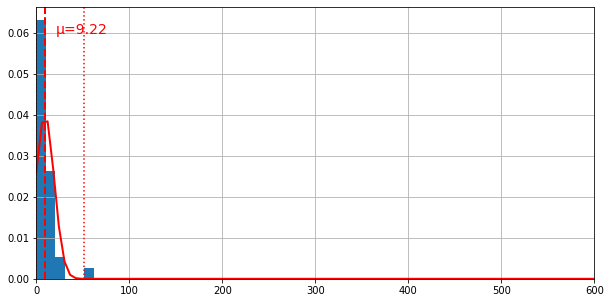

In [51]:
σ = df_instance['Delay(min)'].std()
μ = df_instance['Delay(min)'].mean()
norm = stats.norm(loc=μ, scale=σ).pdf
plot(df_instance['Delay(min)'], pdf=norm, xmin=0, xmax=600, bins=np.linspace(0, 400, 40))
print(f"{max((μ-df_instance['Delay(min)'].min())/σ,  (df_instance['Delay(min)'].max()-μ)/σ):3.1f}σ")

## Average Delay Distribution for all the Runs

In [45]:
df_compare_runs['Average_Delay'].describe()

count    100.000000
mean      14.754900
std       13.352373
min        0.410000
25%        5.935000
50%       12.785000
75%       19.162500
max      103.920000
Name: Average_Delay, dtype: float64

6.7σ


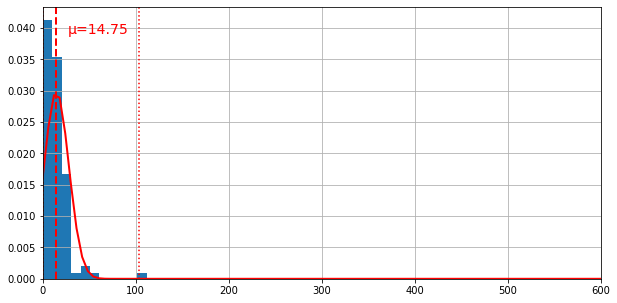

In [46]:
σ = df_compare_runs['Average_Delay'].std()
μ = df_compare_runs['Average_Delay'].mean()
norm = stats.norm(loc=μ, scale=σ).pdf
plot(df_compare_runs['Average_Delay'], pdf=norm, xmin=0, xmax=600, bins=np.linspace(0, 600, 60))
print(f"{max((μ-df_compare_runs['Average_Delay'].min())/σ,  (df_compare_runs['Average_Delay'].max()-μ)/σ):3.1f}σ")

## Analysing the relationship between the variables

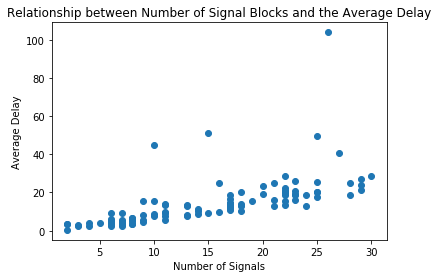

In [61]:
plt.scatter(df_compare_runs[['Number_of_Signals']], df_compare_runs[['Average_Delay']])
plt.title("Relationship between Number of Signal Blocks and the Average Delay")
plt.xlabel("Number of Signals")
plt.ylabel("Average Delay")
plt.show()

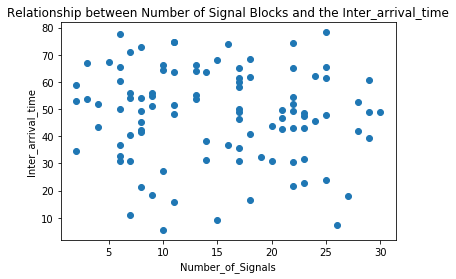

In [94]:
plt.scatter(df_compare_runs[['Number_of_Signals']], df_compare_runs[['Inter_arrival_time']])
plt.title("Relationship between Number of Signal Blocks and the Inter_arrival_time")
plt.xlabel("Number_of_Signals")
plt.ylabel("Inter_arrival_time")
plt.show()

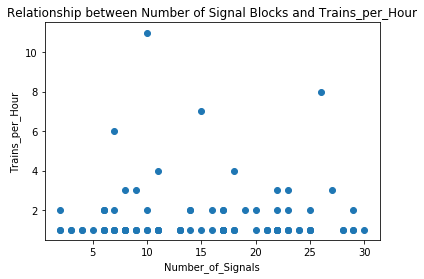

In [96]:
plt.scatter(df_compare_runs[['Number_of_Signals']], df_compare_runs[['Trains_per_Hour']])
plt.title("Relationship between Number of Signal Blocks and Trains_per_Hour")
plt.xlabel("Number_of_Signals")
plt.ylabel("Trains_per_Hour")
plt.show()

### Since, Number of Signals have a linear relationship with the other dependent variables, therefore, Linear Regression has been performed for predicting 'k'

In [78]:
pd.options.mode.chained_assignment = None
 
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np
pd.options.mode.chained_assignment = None
target = df_compare_runs['Number_of_Signals']
predictor = df_compare_runs[['Inter_arrival_time', 'Average_Delay', 'Trains_per_Hour']]
predictor = sm.add_constant(predictor)
 
model = sm.OLS(target, predictor).fit()
predictions = model.predict(predictor)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Number_of_Signals   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     45.26
Date:                Wed, 26 Aug 2020   Prob (F-statistic):           2.56e-18
Time:                        17:03:21   Log-Likelihood:                -301.08
No. Observations:                 100   AIC:                             610.2
Df Residuals:                      96   BIC:                             620.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 17.1729      2.696      6.369      0.000      11.820      22.525
Inter_arrival_time    -0.0936      0.042     -2.202      0.030      -0.178      -0.009
Average_Delay          0.5366      0.047     11.503      0.000       0.444       0.629
Trains_per_Hour       -3.4871      0.540     -6.454      0.000      -4.560      -2.415
==============================================================================
Omnibus:                        4.021   Durbin-Watson:                   2.364
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                3.431
Skew:                          -0.339   Prob(JB):                        0.180
Kurtosis:                       3.603   Cond. No.                         284.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The predictor is set to be Number of Signals, and all the other variables seem to be significant for this linear regression with p-value < 0.05. For this study, the errors have been ignored

### Defining the function for predicting 'k' and plugging in the coefficients obtained from the regression summary

In [82]:
def f(x,y,z):
    return 17.1729-0.0936*x+0.5466*y-3.4871*z

## Read the results of the Optimization algorithms stored as a CSV file

In [84]:
df_optimise = pd.read_csv('MSO_Optimization.csv')
df_optimise

,Optimization_Algorithms,Average_Delay,Inter_Arrival_Time,Number_of_Trains
0,Monte Carlo,13,30,1.96
1,Greedy Hill Climbing,15,30,1.99
2,Simulated Annealing,11,27,2.08


In [91]:
df_optimise.describe()

,Average_Delay,Inter_Arrival_Time,Number_of_Trains
count,3.0,3.000000,3.00000
mean,13.0,29.000000,2.01000
std,2.0,1.732051,0.06245
min,11.0,27.000000,1.96000
25%,12.0,28.500000,1.97500
50%,13.0,30.000000,1.99000
75%,14.0,30.000000,2.03500
max,15.0,30.000000,2.08000


In [87]:
number_of_signals = f(df_optimise['Inter_Arrival_Time'].mean(),df_optimise['Average_Delay'].mean(),\
                      df_optimise['Number_of_Trains'].mean())

In [90]:
round(number_of_signals)

15

# Conclusion

The suggested schedule and layout of the trains has been determined to be - <br>
Number of Signals (k)  </t>     - 15 <br>
Number of Trains Per Hour (n)   - 2

The Number of trains have been maximised to <b>2</b> with the Average Delay time less than or equal to half of the Inter Arrival Time of the consecutive trains